In [1]:
import os
import sys
#
import tensorflow as tf
# limit gpu mem
#gpus = tf.config.list_physical_devices('GPU')
#tf.config.set_logical_device_configuration(gpus[0],[tf.config.LogicalDeviceConfiguration(memory_limit=3700)])
#
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
logical_gpus = tf.config.list_logical_devices('GPU')
print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.layers import (
    Activation, AveragePooling2D, BatchNormalization, Conv2D, Conv2DTranspose, GaussianNoise,
    Dense, Dropout, Flatten, Input, LeakyReLU, ReLU, UpSampling2D)
from tensorflow.keras.models import Sequential, Model
from time import time

import numpy as np
import cv2
import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from tensorflow.keras import Input
#from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import Conv2D
#
from matplotlib import pyplot
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img,save_img
#from keras.utils.vis_utils import plot_model
from copy import deepcopy

from skimage.color import rgb2lab, lab2rgb, rgb2hsv, hsv2rgb
from PIL import Image

convstride_enc=np.array([[[3,3],[1,1]],[[3,3],[2,2]],[[3,3],[2,2]],[[3,3],[2,2]],[[3,3],[2,2]],[[3,3],[2,2]]])
convstride_dec=np.array([[[3,3],[1,1]],[[3,3],[1,1]],[[3,3],[2,2]],[[3,3],[2,2]],[[3,3],[2,2]],[[3,3],[2,2]],[[3,3],[2,2]]])  #[[3,3],[1,1]],[[3,3],[1,1]]
convstride_dis=np.array([[[3,3],[2,2]],[[3,3],[2,2]],[[3,3],[2,2]],[[3,3],[2,2]],[[3,3],[2,2]],[[3,3],[2,2]]])

2023-09-21 14:47:15.298932: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-21 14:47:16.662179: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-09-21 14:47:18.395159: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-21 14:47:19.343211: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

1 Physical GPUs, 1 Logical GPUs


In [2]:
# conversion lab & rgb
def lab_to_rgb(img_lab):
    img_lab = img_lab.numpy()
    L = (img_lab[:,:,:,0] + 1.) * 50. 
    L = L[..., np.newaxis]
    ab = img_lab[:,:,:,1:]  * 110
    img_lab = np.concatenate((L,ab),axis=3)
    #
    img = lab2rgb(img_lab).astype("float32")
    img = (img * 255).astype(np.uint8)
    return img

def rgb_to_lab(img):
    img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b    # float16 to optimize ?
    # Between -1 and 1
    L  = img_lab[:,:,0]  / 50. - 1. 
    ab = img_lab[:,:,1:]  / 110. # Between -1 and 1 
    return L, ab

**MODEL**

In [3]:
# define an encoder block
def define_encoder_block(layer_in,name, n_filters,kernel=(3,3),strides=(2,2), batchnorm=True, pad='same'):
        # weight initialization
        init = RandomNormal(stddev=0.02)
        # padding
        if (pad == 'valid'):
            layer_in = tf.pad(layer_in, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")
        # add downsampling layer
        g = Conv2D(n_filters, kernel, strides=strides, padding=pad, kernel_initializer=init,name=name)(layer_in)
        # conditionally add batch normalization
        if batchnorm:
            g = BatchNormalization()(g, training=True)
        # leaky relu activation
        g = LeakyReLU(alpha=0.2)(g)
        return g

# define a decoder block
def decoder_block(layer_in, skip_in,name, n_filters,kernel=(3,3),strides=(2,2), dropout=True):
        # weight initialization
        init = RandomNormal(stddev=0.02)
        # add upsampling layer
        g = Conv2DTranspose(n_filters, kernel, strides=strides, padding='same', kernel_initializer=init,name=name)(layer_in)
        # add batch normalization
        g = BatchNormalization()(g, training=True)
        # conditionally add dropout
        if dropout:
            g = Dropout(0.3)(g, training=True)
        # merge with skip connection
        g = Concatenate()([g, skip_in])
        # relu activation
        g = Activation('relu')(g)
        return g

# define the standalone generator model
def define_generator(image_shape):   # input L : 480x640x1, output ab : 480x640x1 
        convstrideg=convstride_enc.copy()
        print(convstrideg.shape)
        init = RandomNormal(stddev=0.02)
        # image input
        in_image = Input(shape=image_shape)
        # encoder model
        (conv,stride),convstrideg=convstrideg[0,:,:],convstrideg[1:,:,:]
        e0 = define_encoder_block(in_image,"encoder_block_0", 32, kernel=conv,strides=stride, pad='valid') # 64  pad='valid'
        
        (conv,stride),convstrideg=convstrideg[0,:,:],convstrideg[1:,:,:]
        e1 = define_encoder_block(e0,"encoder_block_1", 64, kernel=conv,strides=stride) # 64
        
        (conv,stride),convstrideg=convstrideg[0,:,:],convstrideg[1:,:,:]
        e2 = define_encoder_block(e1,"encoder_block_2", 128,kernel=conv,strides=stride) # 16
        
        (conv,stride),convstrideg=convstrideg[0,:,:],convstrideg[1:,:,:]
        e3 = define_encoder_block(e2,"encoder_block_3", 256,kernel=conv,strides=stride) # 16
        
        (conv,stride),convstrideg=convstrideg[0,:,:],convstrideg[1:,:,:]
        e4 = define_encoder_block(e3,"encoder_block_4", 512,kernel=conv,strides=stride) # 16
        # bottleneck, no batch norm and relu
        (conv,stride),convstrideg=convstrideg[0,:,:],convstrideg[1:,:,:]
        b = Conv2D(512, conv,strides=stride, padding='same', kernel_initializer=init,name="bottleneck_conv2d")(e4)
        b = Activation('relu')(b)
        # decoder model
        convstrideg=convstride_dec.copy()
        (conv,stride),convstrideg=convstrideg[-1,:,:],convstrideg[:-1,:,:]
        d4 = decoder_block(b, e4,"decoder_block_4", 512,kernel=conv,strides=stride, dropout=False)
        (conv,stride),convstrideg=convstrideg[-1,:,:],convstrideg[:-1,:,:]
        d5 = decoder_block(d4, e3,"decoder_block_3",256,kernel=conv,strides=stride, dropout=False)
        (conv,stride),convstrideg=convstrideg[-1,:,:],convstrideg[:-1,:,:]
        d6 = decoder_block(d5, e2,"decoder_block_2", 128,kernel=conv,strides=stride, dropout=False)
        (conv,stride),convstrideg=convstrideg[-1,:,:],convstrideg[:-1,:,:]
        d7 = decoder_block(d6, e1,"decoder_block_1", 64,kernel=conv,strides=stride, dropout=False)
        (conv,stride),convstrideg=convstrideg[-1,:,:],convstrideg[:-1,:,:]
        d8 = decoder_block(d7, e0,"decoder_block_0", 48,kernel=conv,strides=stride, dropout=False)
        # output
        (conv,stride),convstrideg=convstrideg[-1,:,:],convstrideg[:-1,:,:]
        g = tf.pad(d8, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")
        g = Conv2D(48, conv,strides=stride, padding='valid',kernel_initializer=init, name="1st_last_layer")(g) 
        #(conv,stride),convstrideg=convstrideg[-1,:,:],convstrideg[:-1,:,:]
        #g = tf.pad(g, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")
        #g = Conv2D(42, conv,strides=stride, padding='valid',kernel_initializer=init, name="2nd_last_layer")(g)  
        (conv,stride),convstrideg=convstrideg[-1,:,:],convstrideg[:-1,:,:]
        g = tf.pad(g, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")
        g = Conv2D(3, conv,strides=stride, padding='valid',kernel_initializer=init, name="3rd_last_layer")(g)    
        out_image = Activation('tanh')(g)
        
        # define model
        model = Model(in_image, out_image)
        model.summary()
        return model


# define the discriminator model
def define_discriminator(image_shape):    # input concatenate(L,ab) : 480x640x3, output : 1,0
        convstrided=convstride_dis.copy()
        print(convstrided.shape)
        # weight initialization
        init = RandomNormal(stddev=0.02)
        # source image input
        in_src_image = Input(shape=image_shape)
        # C64
        (conv,stride),convstrided=convstrided[0,:,:],convstrided[1:,:,:]
        d = Conv2D(32, conv, strides=stride, padding='same', kernel_initializer=init)(in_src_image)
        d = LeakyReLU(alpha=0.2)(d)
        # C128
        (conv,stride),convstrided=convstrided[0,:,:],convstrided[1:,:,:]
        d = Conv2D(64, conv, strides=stride, padding='same', kernel_initializer=init)(d)
        d = BatchNormalization()(d)
        d = LeakyReLU(alpha=0.2)(d)
        # C256
        (conv,stride),convstrided=convstrided[0,:,:],convstrided[1:,:,:]
        d = Conv2D(128, conv, strides=stride, padding='same', kernel_initializer=init)(d)
        d = BatchNormalization()(d)
        d = LeakyReLU(alpha=0.2)(d)
        # second last output layer
        (conv,stride),convstrided=convstrided[0,:,:],convstrided[1:,:,:]
        d = Conv2D(256, conv, strides=stride, padding='same', kernel_initializer=init)(d)
        d = BatchNormalization()(d)
        d = LeakyReLU(alpha=0.2)(d)
        # last output layer
        (conv,stride),convstrided=convstrided[0,:,:],convstrided[1:,:,:]
        d = Conv2D(512, conv, strides=stride, padding='same', kernel_initializer=init)(d)
        d = BatchNormalization()(d)
        d = LeakyReLU(alpha=0.2)(d)
        # patch output
        (conv,stride),convstrided=convstrided[0,:,:],convstrided[1:,:,:]
        d = Conv2D(1, conv, strides=stride, padding='same', kernel_initializer=init)(d)
        patch_out = Activation('sigmoid')(d)
        # define model
        model = Model(in_src_image, patch_out)
        model.summary()
        return model
        

**LOSS**

In [4]:
LAMBDA = 60 #10
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = cross_entropy(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = cross_entropy(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.25 * loss

def SSL_loss(real_image, fake_image):
    loss = tf.reduce_mean(tf.abs(real_image - fake_image))
    return 2 * LAMBDA * loss

def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 0.5 * LAMBDA * loss1

def gan_loss(disc_generated_A):
    gan_loss = cross_entropy(tf.ones_like(disc_generated_A), disc_generated_A)
    return gan_loss

def GEN_total_loss(GEN_X, GEN_Y, im_X, im_Y, gen_output_X_Y_bar, gen_output_Y_X_bar, disc_generated_X, disc_generated_Y ):
    id_X_loss = identity_loss(im_Y, GEN_X(im_Y))
    id_Y_loss = identity_loss(im_X, GEN_Y(im_X))
            
    cycle_X_loss= calc_cycle_loss(gen_output_Y_X_bar, im_X)
    cycle_Y_loss= calc_cycle_loss(gen_output_X_Y_bar, im_Y)
    cycle_total_loss = cycle_X_loss + cycle_Y_loss
            
    gan_X_loss = gan_loss(disc_generated_Y)
    gan_Y_loss = gan_loss(disc_generated_X)
    
    total_X = gan_X_loss + cycle_X_loss + id_X_loss    #cycle_total_loss
    total_Y = gan_Y_loss + cycle_Y_loss + id_Y_loss    #cycle_total_loss
    
    return total_X, gan_X_loss, id_X_loss, total_Y, gan_Y_loss, id_Y_loss, cycle_total_loss
    
    
# old loss
def generator_loss(disc_generated_A, gen_output_A_B_bar, img_B):
    gan_loss = cross_entropy(tf.ones_like(disc_generated_A), disc_generated_A)
    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(gen_output_A_B_bar - img_B))
    #
    total_gen_loss = gan_loss + (LAMBDA*l1_loss)
    return total_gen_loss, gan_loss, l1_loss

In [5]:
GEN_X = define_generator(image_shape=(256,256,3))
DISC_X = define_discriminator(image_shape=(256,256,3))

GEN_X_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)    #2e-4
DISC_X_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)  #2e-4

GEN_Y = define_generator(image_shape=(256,256,3))
DISC_Y = define_discriminator(image_shape=(256,256,3))

GEN_Y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)    #2e-4
DISC_Y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)  #2e-4

(6, 2, 2)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 tf.compat.v1.pad (TFOpLamb  (None, 258, 258, 3)          0         ['input_1[0][0]']             
 da)                                                                                              
                                                                                                  
 encoder_block_0 (Conv2D)    (None, 256, 256, 32)         896       ['tf.compat.v1.pad[0][0]']    
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 32)         128       ['encoder_block_

                                                                                                  
 decoder_block_1 (Conv2DTra  (None, 128, 128, 64)         147520    ['activation_3[0][0]']        
 nspose)                                                                                          
                                                                                                  
 batch_normalization_8 (Bat  (None, 128, 128, 64)         256       ['decoder_block_1[0][0]']     
 chNormalization)                                                                                 
                                                                                                  
 concatenate_3 (Concatenate  (None, 128, 128, 128)        0         ['batch_normalization_8[0][0]'
 )                                                                  , 'leaky_re_lu_1[0][0]']      
                                                                                                  
 activatio

/home/anton/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


(6, 2, 2)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_10 (Ba  (None, 64, 64, 64)        256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                 

 nspose)                                                                                          
                                                                                                  
 batch_normalization_19 (Ba  (None, 16, 16, 512)          2048      ['decoder_block_4[0][0]']     
 tchNormalization)                                                                                
                                                                                                  
 concatenate_5 (Concatenate  (None, 16, 16, 1024)         0         ['batch_normalization_19[0][0]
 )                                                                  ',                            
                                                                     'leaky_re_lu_14[0][0]']      
                                                                                                  
 activation_9 (Activation)   (None, 16, 16, 1024)         0         ['concatenate_5[0][0]']       
          

                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 64, 64, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 batch_normalization_25 (Ba  (None, 32, 32, 128)       512       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 batch_normalization_26 (Ba  (None, 16, 16, 256)       1024      
 tchNormalization)                                               
                                                                 
 leaky_re_

**UTILS**

In [6]:
# plot real source images
def summarize_performance(step, img_X_B, img_X_Y, img_Y_B, img_Y_X):
    X_B = (img_X_B[-1] +1.0) / 2.0   # -1
    X_Y = (img_X_Y[0] +1.0 ) / 2.0   
    Y_B = (img_Y_B[-1] +1.0) / 2.0   # -1
    Y_X = (img_Y_X[0] + 1.0) / 2.0

    pyplot.subplot(2, 2, 1)
    pyplot.axis('off')       
    pyplot.imshow(X_B)
    pyplot.title('X org')
    
    pyplot.subplot(2, 2, 2)
    pyplot.axis('off')       
    pyplot.imshow(X_Y) 
    pyplot.title('X org -> Y')

    pyplot.subplot(2, 2, 3)
    pyplot.axis('off')       
    pyplot.imshow(Y_B)  #*255   
    pyplot.title('Y org')

    pyplot.subplot(2, 2, 4)
    pyplot.axis('off')       
    pyplot.imshow(Y_X) 
    pyplot.title('Y org -> X')

    # save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()

def test_loss_avg(GEN_X, DISC_Y,path):
    Loss_avg = list()
    #L1_avg = list()

    IMAGE=os.listdir(path)
    IMAGE.sort()
    
    for file_img in IMAGE:
        print(file_img)
        new_im = os.path.join(path,file_img)

        # now read the input image files (difference from the code it is derived from that preloads all images)
        pixels = Image.open(new_im).convert("RGB")
        pixels = np.array(pixels)
        pixels = pixels[np.newaxis, ...]
        #
        img_Y_fake = GEN_X(pixels, training=False)
        #
        disc_on_test = DISC_Y(img_Y_fake,training=False)
        #
        test_loss = gan_loss(disc_on_test)
        #test_loss, gan_loss, l1_loss=generator_loss(disc_on_test, img_Y_fake, pixels)
        Loss_avg.append(test_loss)
        #L1_avg.append(l1_loss)
        
    avg = np.mean(Loss_avg) 
    #l1 = np.mean(L1_avg)
    return avg

def shuffle_and_batch(Dataset, buff_size, SEED, BATCH_SIZE):
    # SHUFFLE
    Dataset_S = Dataset.shuffle(buffer_size = buff_size,seed=SEED)    #10 * BATCH_SIZE   L_dataset.cardinality()
    # Batch
    Dataset_B = Dataset_S.batch(BATCH_SIZE)
    return(Dataset_B)

def change_Bright(image,B):        #run_eagerly=True   ???
    img = rgb2hsv(image[0:1]*127.5 + 127.5)
    img[:,:,:,2] = np.clip(img[:,:,:,2]*B,0,255)
    img = (hsv2rgb(img) - 127.5) / 127.5
    img_final = tf.keras.layers.concatenate([img, image[1:]],axis=0)
    return img_final

In [7]:
# GEN_X -->  Generator from X to Y
# DISC_X --> Discriminator of X images
# ...

@tf.function
def train_step(GEN_X, DISC_X, GEN_Y, DISC_Y, img_X, img_Y, SS_X, SS_Y, batch):  
    GLX=DLX= tf.constant(0.)
    GLY=DLY= tf.constant(0.)
    GANX=GANY=tf.constant(0.)
    IDX=IDY= tf.constant(0.)
    CYCLE =  tf.constant(0.)
    # for each image of the batch
    with tf.GradientTape() as genX_tape, tf.GradientTape() as discX_tape, tf.GradientTape() as genY_tape, tf.GradientTape() as discY_tape:
        for i in range(batch):
            #  X --> Y --> X_bar  #
            gen_output_X_Y = GEN_X(img_X[i:i+1], training=True)
            gen_output_Y_X_bar = GEN_Y(gen_output_X_Y, training=True)
            #  Y --> X --> Y_bar  #
            gen_output_Y_X = GEN_Y(img_Y[i:i+1], training=True)
            gen_output_X_Y_bar = GEN_X(gen_output_Y_X, training=True)
            #
            #  DISCRIMINATOR generated losses  #
            disc_generated_X = DISC_X(gen_output_Y_X , training=True)
            disc_generated_Y = DISC_Y(gen_output_X_Y, training=True)
            #  DISCRIMINATOR Real losses  #
            disc_real_X = DISC_X(img_X[i:i+1], training=True)
            disc_real_Y = DISC_Y(img_Y[i:i+1], training=True)
            #  DISCRIMINATOR total losses  #
            disc_loss_X = discriminator_loss(disc_real_X, disc_generated_X)
            disc_loss_Y = discriminator_loss(disc_real_Y, disc_generated_Y)
            #
            TOTAL_X, gan_X_loss, id_X_loss, TOTAL_Y, gan_Y_loss, id_Y_loss, CYCLE_loss = GEN_total_loss(GEN_X, GEN_Y, img_X[i:i+1], img_Y[i:i+1], gen_output_X_Y_bar, gen_output_Y_X_bar, disc_generated_X, disc_generated_Y)
            #
            DLX=tf.add(DLX,disc_loss_X)
            GLX=tf.add(GLX,TOTAL_X)
            DLY=tf.add(DLY,disc_loss_Y)
            GLY=tf.add(GLY,TOTAL_Y)
            #
            GANX = tf.add(GANX, gan_X_loss)
            IDX = tf.add(IDX, id_X_loss)
            GANY = tf.add(GANX, gan_X_loss)
            IDY = tf.add(IDX, id_X_loss)
            CYCLE = tf.add(CYCLE, CYCLE_loss)
            
        # mean of batch loss
        DLX = tf.math.divide(DLX,batch)
        GLX = tf.math.divide(GLX,batch)
        DLY = tf.math.divide(DLY,batch)
        GLY = tf.math.divide(GLY,batch)
        GANX= tf.math.divide(GANX,batch)
        IDX = tf.math.divide(IDX,batch)
        GANY= tf.math.divide(GANY,batch)
        IDY = tf.math.divide(IDY,batch)
        CYCLE=tf.math.divide(CYCLE,batch)
        
        # Semi Supervised Loss
        fake_SS_Y = GEN_X(SS_X, training = True)  
        ssl_X_loss = SSL_loss(SS_Y, fake_SS_Y)
        #tf.print('Semi supervised loss :', ssl_X_loss)
        GLX=tf.add(GLX,ssl_X_loss)
            
        # Update at the end of batch
        generator_gradients_X = genX_tape.gradient(GLX,
                                                GEN_X.trainable_variables)
        discriminator_gradients_X = discX_tape.gradient(DLX,
                                                     DISC_X.trainable_variables)
        GEN_X_optimizer.apply_gradients(zip(generator_gradients_X,
                                              GEN_X.trainable_variables))
        DISC_X_optimizer.apply_gradients(zip(discriminator_gradients_X,
                                                  DISC_X.trainable_variables))
        
        generator_gradients_Y = genY_tape.gradient(GLY,
                                                GEN_Y.trainable_variables)
        discriminator_gradients_Y = discY_tape.gradient(DLY,
                                                     DISC_Y.trainable_variables)
        GEN_Y_optimizer.apply_gradients(zip(generator_gradients_Y,
                                              GEN_Y.trainable_variables))
        DISC_Y_optimizer.apply_gradients(zip(discriminator_gradients_Y,
                                                  DISC_Y.trainable_variables))

    return GLX, DLX, GLY, DLY, gen_output_X_Y, gen_output_Y_X, GANX, IDX, GANY, IDY, CYCLE, ssl_X_loss


# train pix2pix models
def train(GEN_X, DISC_X, GEN_Y, DISC_Y, dataset, dataset_ssl, batch=4):
    # determine the output square shape of the discriminator
    n_patch1 = DISC_X.output_shape[1]
    n_patch2 = DISC_X.output_shape[2]
    # calculate the number of batches per training epoch
    #
    GLoss = []
    DLoss = []
    GanX = []
    GanY= []
    IdX= []
    IdY= []
    Cycle= []
    SSL_Loss=[]
    #
    i=0
    # manually enumerate batch
    for data, data_ssl in zip(dataset, dataset_ssl):
        img_X = data[:,:,:,:3]
        img_Y = data[:,:,:,3:]
        SS_X = data_ssl[:,:,:,:3]
        SS_Y = data_ssl[:,:,:,3:]
        # BRIGHT +/-
        bright = np.clip(np.random.normal(0.9,0.2),0.7,1.1)  # (0.9,0.2),0.8,1.1)    (0.8,0.25),0.7,1.2) 
        img_X_B = change_Bright(img_X,bright)
        img_Y_B = change_Bright(img_Y,bright)
        SS_X_B = change_Bright(SS_X,bright)
        SS_Y_B = change_Bright(SS_Y,bright-0.05)
        # train step, update loss, gradient
        gen_loss_X, disc_loss_X, gen_loss_Y, disc_loss_Y, img_X_Y, img_Y_X, GANX, IDX, GANY, IDY, CYCLE, SSL = train_step(GEN_X, DISC_X, GEN_Y, DISC_Y, img_X_B, img_Y_B, SS_X_B, SS_Y_B, batch)    # tf.constant()
        #
        print("step "+str(i)+" gen_loss : "+str(gen_loss_X.numpy())+" disc_loss : "+str(disc_loss_X.numpy())+" Bright coef : "+str(bright))
        GLoss.append(gen_loss_X.numpy())
        DLoss.append(disc_loss_X.numpy())
        GanX.append(GANX.numpy())
        GanY.append(GANY.numpy())
        IdX.append(IDX.numpy())
        IdY.append(IDY.numpy())
        Cycle.append(CYCLE.numpy())
        SSL_Loss.append(SSL.numpy())
        # summarize model performance every 200 steps
        if (i % 20 == 0) and (i !=0):
            summarize_performance(i, img_X_B, img_X_Y, img_Y_B, img_Y_X)
        i+=1
    return(DLoss, GLoss, GEN_X, DISC_X, GEN_Y, DISC_Y, GanX, GanY, IdX, IdY, Cycle, SSL_Loss)


Learning Rate G : 0.0002 Learning Rate D : 0.0002
Seed :  9107

Start of epoch 1


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 16963992721683703832
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 11632619973952462886
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing 

step 0 gen_loss : 67.723656 disc_loss : 1.7080759 Bright coef : 0.7155841187535508
step 1 gen_loss : 88.81449 disc_loss : 1.5769436 Bright coef : 1.066134156403814
step 2 gen_loss : 69.47103 disc_loss : 1.5534803 Bright coef : 0.9530001824735688
step 3 gen_loss : 74.68785 disc_loss : 1.4332651 Bright coef : 0.9728713408964687
step 4 gen_loss : 69.14555 disc_loss : 1.3125057 Bright coef : 0.7
step 5 gen_loss : 55.92116 disc_loss : 1.2528768 Bright coef : 1.1
step 6 gen_loss : 78.538574 disc_loss : 1.5127714 Bright coef : 0.7
step 7 gen_loss : 27.435852 disc_loss : 1.6957937 Bright coef : 0.859966084953656
step 8 gen_loss : 35.20986 disc_loss : 1.4652497 Bright coef : 0.7
step 9 gen_loss : 60.0185 disc_loss : 1.5250793 Bright coef : 0.9353754681557734
step 10 gen_loss : 26.123938 disc_loss : 1.3844519 Bright coef : 0.7
step 11 gen_loss : 40.144142 disc_loss : 2.0536375 Bright coef : 1.1
step 12 gen_loss : 63.63922 disc_loss : 2.086838 Bright coef : 0.7188815263521735
step 13 gen_loss : 2

step 105 gen_loss : 77.407555 disc_loss : 1.4854156 Bright coef : 1.1
step 106 gen_loss : 33.349155 disc_loss : 1.3397855 Bright coef : 0.7923074083060383
step 107 gen_loss : 33.54547 disc_loss : 1.506846 Bright coef : 0.7
step 108 gen_loss : 69.64836 disc_loss : 1.4108267 Bright coef : 1.1
step 109 gen_loss : 33.660625 disc_loss : 1.5156331 Bright coef : 0.8805252467599742
step 110 gen_loss : 34.744072 disc_loss : 1.3650956 Bright coef : 1.1
step 111 gen_loss : 17.926796 disc_loss : 1.310504 Bright coef : 0.7
step 112 gen_loss : 22.493435 disc_loss : 1.3120573 Bright coef : 0.9421817497198619
step 113 gen_loss : 42.040997 disc_loss : 1.7458196 Bright coef : 1.1
step 114 gen_loss : 20.613846 disc_loss : 1.2119877 Bright coef : 0.7612429106869403
step 115 gen_loss : 20.463823 disc_loss : 1.2539996 Bright coef : 0.8651106876175205
step 116 gen_loss : 44.08139 disc_loss : 1.7800437 Bright coef : 0.7
step 117 gen_loss : 30.14585 disc_loss : 1.4968915 Bright coef : 0.8618404310004235
step 1

step 209 gen_loss : 49.961067 disc_loss : 1.2586231 Bright coef : 1.0647945689317169
step 210 gen_loss : 17.964457 disc_loss : 1.207619 Bright coef : 1.0917763867258246
step 211 gen_loss : 28.571941 disc_loss : 1.3100898 Bright coef : 0.9041412301058294
step 212 gen_loss : 29.45184 disc_loss : 1.1967993 Bright coef : 1.0309083243001056
step 213 gen_loss : 44.31242 disc_loss : 1.2651236 Bright coef : 0.7
step 214 gen_loss : 35.89411 disc_loss : 1.3992381 Bright coef : 0.7
step 215 gen_loss : 35.386055 disc_loss : 1.0086865 Bright coef : 0.9515811124087421
step 216 gen_loss : 30.006641 disc_loss : 0.9199959 Bright coef : 0.844222816647945
step 217 gen_loss : 27.409454 disc_loss : 1.840105 Bright coef : 0.7861650277425928
step 218 gen_loss : 19.728012 disc_loss : 1.2096933 Bright coef : 1.0286853045620714
step 219 gen_loss : 43.43158 disc_loss : 1.6736383 Bright coef : 0.7
step 220 gen_loss : 18.9114 disc_loss : 1.2118388 Bright coef : 0.7
step 221 gen_loss : 55.928288 disc_loss : 1.26017

step 311 gen_loss : 38.294685 disc_loss : 0.93971896 Bright coef : 1.1
step 312 gen_loss : 26.633205 disc_loss : 1.1768099 Bright coef : 0.7
step 313 gen_loss : 20.907225 disc_loss : 1.463834 Bright coef : 1.0325614041621356
step 314 gen_loss : 27.881601 disc_loss : 1.5609348 Bright coef : 1.1
step 315 gen_loss : 34.154747 disc_loss : 1.5547457 Bright coef : 0.7529196662853389
step 316 gen_loss : 15.544972 disc_loss : 1.1662045 Bright coef : 0.9022698970893559
step 317 gen_loss : 30.60902 disc_loss : 1.0725818 Bright coef : 1.0932958265750656
step 318 gen_loss : 15.435944 disc_loss : 1.1619704 Bright coef : 0.9224456563312567
step 319 gen_loss : 37.701122 disc_loss : 1.1581246 Bright coef : 0.9345696895575184
step 320 gen_loss : 41.38115 disc_loss : 0.96832633 Bright coef : 0.7
step 321 gen_loss : 16.528383 disc_loss : 1.1834955 Bright coef : 0.8777025605882743
step 322 gen_loss : 23.57449 disc_loss : 1.4788061 Bright coef : 0.856635855960398
step 323 gen_loss : 29.79657 disc_loss : 1.

step 417 gen_loss : 62.862495 disc_loss : 0.714851 Bright coef : 1.1
step 418 gen_loss : 35.45852 disc_loss : 1.5890017 Bright coef : 1.0323394596799667
step 419 gen_loss : 25.009428 disc_loss : 1.3653489 Bright coef : 0.9642161861517644
step 420 gen_loss : 35.4221 disc_loss : 0.9725138 Bright coef : 0.8559009405450554
step 421 gen_loss : 19.151623 disc_loss : 0.7287453 Bright coef : 1.0597976568077612
step 422 gen_loss : 24.697079 disc_loss : 0.71060205 Bright coef : 0.778002621082476
step 423 gen_loss : 19.171598 disc_loss : 0.79722214 Bright coef : 1.0805528212544286
step 424 gen_loss : 47.61316 disc_loss : 1.5358362 Bright coef : 0.7
step 425 gen_loss : 27.63173 disc_loss : 1.3894932 Bright coef : 0.7650478795876237
step 426 gen_loss : 33.102203 disc_loss : 1.7471282 Bright coef : 1.0305432255511304
step 427 gen_loss : 13.619486 disc_loss : 0.8399869 Bright coef : 0.7857417622228173
step 428 gen_loss : 25.215649 disc_loss : 1.4738586 Bright coef : 0.7511456918218393
step 429 gen_lo

step 521 gen_loss : 21.23458 disc_loss : 0.94126123 Bright coef : 0.8253420845119118
step 522 gen_loss : 25.382732 disc_loss : 1.7008474 Bright coef : 0.9051163619371092
step 523 gen_loss : 28.057838 disc_loss : 1.555906 Bright coef : 0.7102042230696393
image_00000087_2.png
image_00000088-3.png
image_00000092-3.png
image_00000092_1.png
image_00000095_2.png
image_00000096-3.png
image_00000099-3.png
image_00000099_1.png
image_00000107-3.png
image_00000108-3.png
image_00000109-3.png
image_00000110-3.png
image_00000117-3.png
image_00000118-3.png
image_00000122-3.png
image_00000123-3.png
image_00000128-3.png
image_00000129-3.png
image_00000134-3.png
image_00000135-3.png
image_00000138-3.png
image_00000139-3.png
image_00000147-3.png
image_00000148-3.png
X :  [1]
G :  [32.73222]
D :  [1.3395416]
T_avg :  [1.4572763]


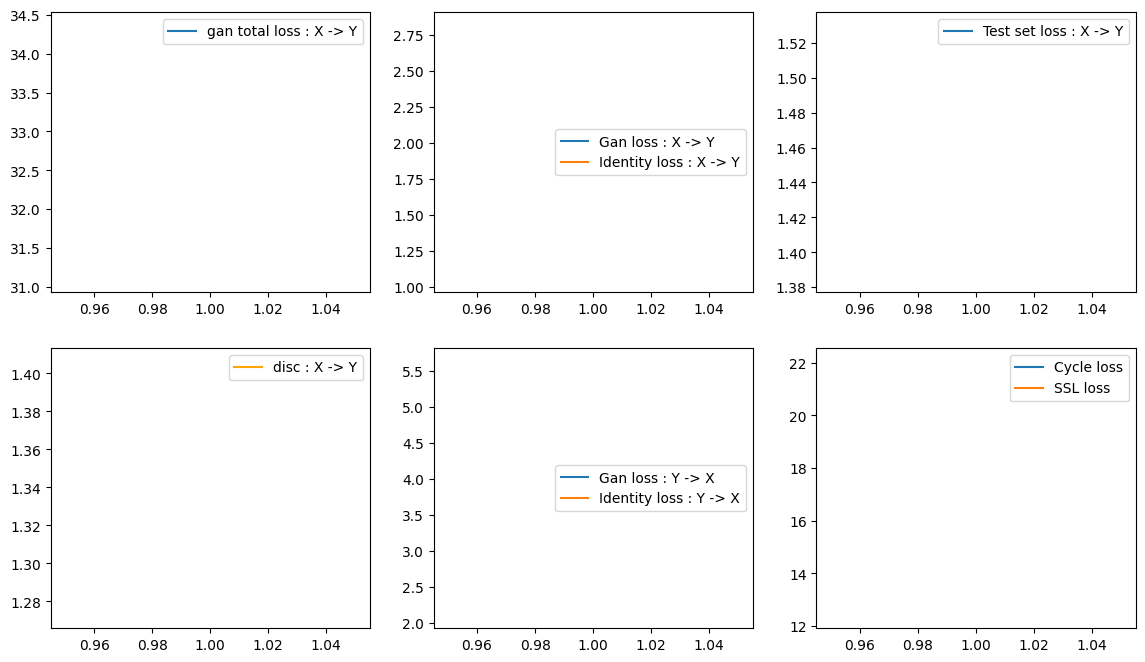

Seed :  2989

Start of epoch 2


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 16963992721683703832
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 11632619973952462886


step 0 gen_loss : 11.757061 disc_loss : 0.88492405 Bright coef : 0.8538045899761686
step 1 gen_loss : 43.922207 disc_loss : 1.4800069 Bright coef : 1.1
step 2 gen_loss : 29.813448 disc_loss : 0.7913767 Bright coef : 1.0600504216756836
step 3 gen_loss : 21.612518 disc_loss : 0.6298088 Bright coef : 1.0440544428082092
step 4 gen_loss : 35.225845 disc_loss : 1.1335018 Bright coef : 0.7
step 5 gen_loss : 64.95335 disc_loss : 0.6285392 Bright coef : 0.980981899752895
step 6 gen_loss : 46.094673 disc_loss : 1.6679022 Bright coef : 0.9699187319041659
step 7 gen_loss : 30.978268 disc_loss : 0.9018202 Bright coef : 0.7
step 8 gen_loss : 19.396294 disc_loss : 0.53686464 Bright coef : 0.8114809649064649
step 9 gen_loss : 20.221634 disc_loss : 0.655656 Bright coef : 0.7848030451941632
step 10 gen_loss : 22.826153 disc_loss : 0.66682386 Bright coef : 1.0032424333241563
step 11 gen_loss : 28.966597 disc_loss : 1.27207 Bright coef : 0.8387488470122887
step 12 gen_loss : 40.90486 disc_loss : 0.8888894

step 107 gen_loss : 37.766228 disc_loss : 0.6708803 Bright coef : 0.935166091798507
step 108 gen_loss : 27.002361 disc_loss : 0.89169383 Bright coef : 0.8466517643119058
step 109 gen_loss : 22.447731 disc_loss : 0.7997452 Bright coef : 0.9638731980502608
step 110 gen_loss : 37.118256 disc_loss : 0.9881836 Bright coef : 0.7
step 111 gen_loss : 22.558084 disc_loss : 1.2399873 Bright coef : 0.7
step 112 gen_loss : 16.298857 disc_loss : 0.68762124 Bright coef : 0.7903167897389485
step 113 gen_loss : 32.84737 disc_loss : 0.8728352 Bright coef : 0.8759943448243404
step 114 gen_loss : 29.487694 disc_loss : 1.1780332 Bright coef : 0.7544619853956798
step 115 gen_loss : 15.98958 disc_loss : 0.74653786 Bright coef : 0.9689131314635978
step 116 gen_loss : 28.809393 disc_loss : 1.0716174 Bright coef : 0.7
step 117 gen_loss : 21.8632 disc_loss : 1.5397615 Bright coef : 0.784830236686462
step 118 gen_loss : 35.22749 disc_loss : 1.329127 Bright coef : 0.9986137731282546
step 119 gen_loss : 54.703827 

step 211 gen_loss : 15.211166 disc_loss : 0.8567236 Bright coef : 0.8288671825564462
step 212 gen_loss : 32.74937 disc_loss : 0.82514066 Bright coef : 0.7700006208696921
step 213 gen_loss : 22.297245 disc_loss : 1.0291846 Bright coef : 0.7
step 214 gen_loss : 27.64859 disc_loss : 0.7205478 Bright coef : 1.1
step 215 gen_loss : 53.107307 disc_loss : 0.82381374 Bright coef : 1.0980102205196236
step 216 gen_loss : 22.690617 disc_loss : 2.0283248 Bright coef : 0.9412135598492307
step 217 gen_loss : 18.236635 disc_loss : 1.1746051 Bright coef : 0.965263314332456
step 218 gen_loss : 19.256706 disc_loss : 1.0620264 Bright coef : 0.9626401485975609
step 219 gen_loss : 17.740116 disc_loss : 1.444485 Bright coef : 1.1
step 220 gen_loss : 34.03948 disc_loss : 0.8580506 Bright coef : 0.9556312927813129
step 221 gen_loss : 32.24148 disc_loss : 0.64764154 Bright coef : 0.9534717173745128
step 222 gen_loss : 18.000206 disc_loss : 1.1903832 Bright coef : 0.8744888212048896
step 223 gen_loss : 28.23006

step 314 gen_loss : 19.231115 disc_loss : 1.2988938 Bright coef : 0.951547353743979
step 315 gen_loss : 19.993969 disc_loss : 2.2735972 Bright coef : 1.000613296444088
step 316 gen_loss : 23.381718 disc_loss : 1.079744 Bright coef : 0.7980918216795747
step 317 gen_loss : 18.620502 disc_loss : 0.9327421 Bright coef : 0.9606672283024974
step 318 gen_loss : 16.807613 disc_loss : 1.0052148 Bright coef : 0.9396432932802992
step 319 gen_loss : 15.776211 disc_loss : 1.2515771 Bright coef : 0.8938644210851561
step 320 gen_loss : 32.265667 disc_loss : 0.523759 Bright coef : 0.9247320011821185
step 321 gen_loss : 18.665243 disc_loss : 0.5003991 Bright coef : 1.0369515220869483
step 322 gen_loss : 31.648405 disc_loss : 2.2397418 Bright coef : 0.9553713306981394
step 323 gen_loss : 31.741106 disc_loss : 0.6203437 Bright coef : 0.9496516348137813
step 324 gen_loss : 33.803658 disc_loss : 0.2977845 Bright coef : 0.8266069735159938
step 325 gen_loss : 20.025356 disc_loss : 0.44931832 Bright coef : 0.

step 415 gen_loss : 19.272854 disc_loss : 0.9879644 Bright coef : 0.7
step 416 gen_loss : 23.213802 disc_loss : 1.640809 Bright coef : 0.7
step 417 gen_loss : 21.59071 disc_loss : 0.9923209 Bright coef : 0.7
step 418 gen_loss : 38.047607 disc_loss : 0.53974754 Bright coef : 0.8852653852800693
step 419 gen_loss : 56.40776 disc_loss : 1.1773249 Bright coef : 1.1
step 420 gen_loss : 31.143105 disc_loss : 1.6437385 Bright coef : 0.8192047137659612
step 421 gen_loss : 40.554787 disc_loss : 0.7126528 Bright coef : 0.7
step 422 gen_loss : 38.830536 disc_loss : 1.1879424 Bright coef : 1.0730572159242706
step 423 gen_loss : 21.503094 disc_loss : 0.92704487 Bright coef : 0.810428462219845
step 424 gen_loss : 16.412983 disc_loss : 0.38910264 Bright coef : 0.9052166638395811
step 425 gen_loss : 31.33245 disc_loss : 1.2382193 Bright coef : 1.1
step 426 gen_loss : 17.45324 disc_loss : 0.9785409 Bright coef : 0.736530623786182
step 427 gen_loss : 25.985771 disc_loss : 0.36642784 Bright coef : 0.97938

step 517 gen_loss : 39.239513 disc_loss : 1.6922896 Bright coef : 0.7
step 518 gen_loss : 30.055935 disc_loss : 0.42801613 Bright coef : 1.1
step 519 gen_loss : 42.389076 disc_loss : 1.3897781 Bright coef : 0.9699283298745042
step 520 gen_loss : 30.750902 disc_loss : 0.78628993 Bright coef : 0.8385264746708261
step 521 gen_loss : 28.830944 disc_loss : 1.7609508 Bright coef : 0.8238854632237077
step 522 gen_loss : 26.046173 disc_loss : 0.7933841 Bright coef : 1.0858233344896413
step 523 gen_loss : 23.09887 disc_loss : 0.74950075 Bright coef : 0.9774839526262965
image_00000087_2.png
image_00000088-3.png
image_00000092-3.png
image_00000092_1.png
image_00000095_2.png
image_00000096-3.png
image_00000099-3.png
image_00000099_1.png
image_00000107-3.png
image_00000108-3.png
image_00000109-3.png
image_00000110-3.png
image_00000117-3.png
image_00000118-3.png
image_00000122-3.png
image_00000123-3.png
image_00000128-3.png
image_00000129-3.png
image_00000134-3.png
image_00000135-3.png
image_0000013

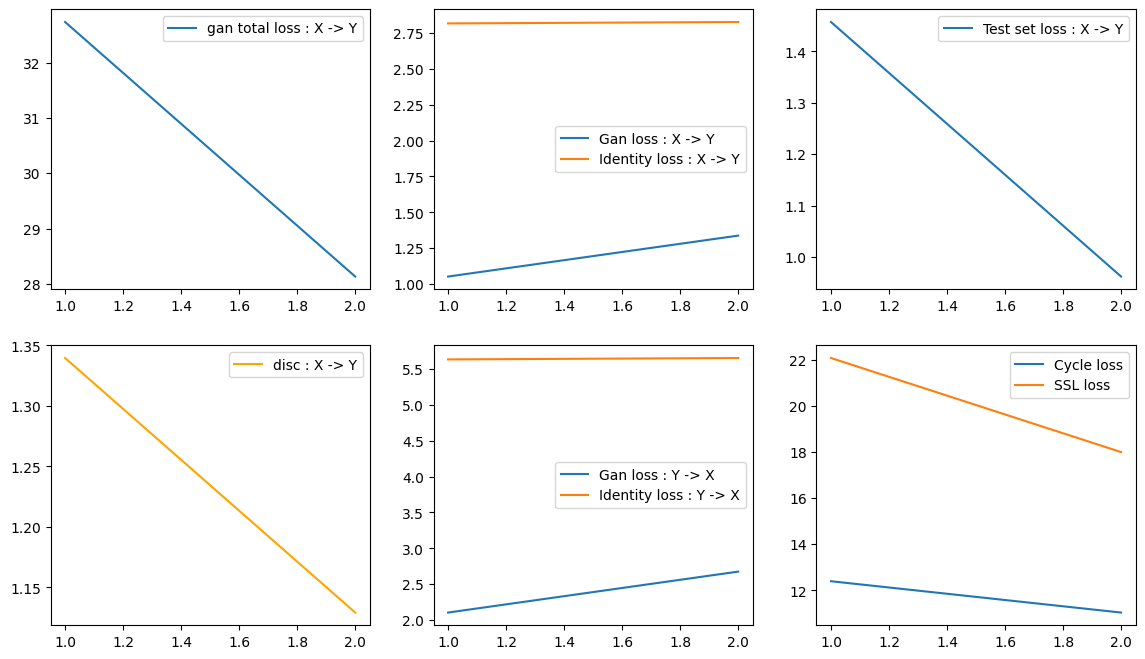

Seed :  1776

Start of epoch 3


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 16963992721683703832
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 11632619973952462886


step 0 gen_loss : 21.577465 disc_loss : 1.2799882 Bright coef : 0.9422781159564911
step 1 gen_loss : 27.491467 disc_loss : 1.0211426 Bright coef : 1.1
step 2 gen_loss : 28.116587 disc_loss : 0.507581 Bright coef : 0.7
step 3 gen_loss : 16.033028 disc_loss : 0.4445583 Bright coef : 0.9146492918631491
step 4 gen_loss : 24.607754 disc_loss : 0.94670427 Bright coef : 0.7195976705355134
step 5 gen_loss : 18.294413 disc_loss : 1.0544834 Bright coef : 0.7
step 6 gen_loss : 21.979832 disc_loss : 0.90796244 Bright coef : 0.7496844306438755
step 7 gen_loss : 41.88015 disc_loss : 0.47977555 Bright coef : 0.9306127213452521
step 8 gen_loss : 19.908 disc_loss : 0.4379863 Bright coef : 0.7
step 9 gen_loss : 18.433512 disc_loss : 0.7094185 Bright coef : 1.07539597008575
step 10 gen_loss : 34.48187 disc_loss : 1.4256798 Bright coef : 1.0255436138001608
step 11 gen_loss : 29.147125 disc_loss : 0.29187474 Bright coef : 1.0760796951121097
step 12 gen_loss : 22.340418 disc_loss : 0.3445285 Bright coef : 0

step 104 gen_loss : 26.794601 disc_loss : 0.7543089 Bright coef : 0.7097528970925968
step 105 gen_loss : 34.876823 disc_loss : 1.39693 Bright coef : 1.032954411228625
step 106 gen_loss : 16.089382 disc_loss : 1.1372988 Bright coef : 0.970587537803218
step 107 gen_loss : 13.35359 disc_loss : 1.1038548 Bright coef : 0.7
step 108 gen_loss : 13.772087 disc_loss : 1.5214303 Bright coef : 0.7
step 109 gen_loss : 34.79593 disc_loss : 0.7692635 Bright coef : 0.942213888347686
step 110 gen_loss : 17.544495 disc_loss : 0.6801152 Bright coef : 0.7
step 111 gen_loss : 16.472485 disc_loss : 1.5909325 Bright coef : 0.915297942204141
step 112 gen_loss : 11.791353 disc_loss : 1.2611622 Bright coef : 0.7603454863725813
step 113 gen_loss : 12.177349 disc_loss : 0.5497804 Bright coef : 0.7
step 114 gen_loss : 23.16963 disc_loss : 0.6344702 Bright coef : 0.7134628480165732
step 115 gen_loss : 18.386412 disc_loss : 0.6464849 Bright coef : 0.7
step 116 gen_loss : 55.18826 disc_loss : 0.4065927 Bright coef :

step 208 gen_loss : 14.380814 disc_loss : 1.5654116 Bright coef : 0.7672621312493973
step 209 gen_loss : 17.200855 disc_loss : 0.6658654 Bright coef : 0.9197808346302768
step 210 gen_loss : 43.64467 disc_loss : 0.92939436 Bright coef : 0.7
step 211 gen_loss : 23.180376 disc_loss : 1.7801517 Bright coef : 0.8411039509557278
step 212 gen_loss : 25.030355 disc_loss : 1.2671807 Bright coef : 0.8284319939891222
step 213 gen_loss : 25.123716 disc_loss : 1.829414 Bright coef : 0.7
step 214 gen_loss : 18.28056 disc_loss : 0.5245578 Bright coef : 0.7908510930924438
step 215 gen_loss : 46.361115 disc_loss : 0.8956645 Bright coef : 0.841211045230404
step 216 gen_loss : 21.284409 disc_loss : 1.8398697 Bright coef : 0.7718645932265871
step 217 gen_loss : 51.78872 disc_loss : 1.8044453 Bright coef : 1.1
step 218 gen_loss : 14.951757 disc_loss : 0.86637497 Bright coef : 0.8185619384291942
step 219 gen_loss : 24.060373 disc_loss : 0.7362865 Bright coef : 1.1
step 220 gen_loss : 18.27289 disc_loss : 0.

step 312 gen_loss : 25.904133 disc_loss : 2.0326235 Bright coef : 1.1
step 313 gen_loss : 12.682225 disc_loss : 0.30856863 Bright coef : 0.7714137796797935
step 314 gen_loss : 31.033384 disc_loss : 1.3501534 Bright coef : 1.1
step 315 gen_loss : 20.248703 disc_loss : 2.3748085 Bright coef : 0.8934293769576899
step 316 gen_loss : 13.811264 disc_loss : 1.580609 Bright coef : 0.9222099616285867
step 317 gen_loss : 35.191505 disc_loss : 1.1881825 Bright coef : 0.7030592273453231
step 318 gen_loss : 14.189928 disc_loss : 0.70739096 Bright coef : 0.8743953129316558
step 319 gen_loss : 17.157402 disc_loss : 0.5697783 Bright coef : 1.0263612073636355
step 320 gen_loss : 28.894466 disc_loss : 1.0193113 Bright coef : 0.8487992163853602
step 321 gen_loss : 16.625134 disc_loss : 0.8902842 Bright coef : 0.882179174689636
step 322 gen_loss : 14.922766 disc_loss : 1.4255555 Bright coef : 0.8451474433422121
step 323 gen_loss : 18.161747 disc_loss : 1.1584461 Bright coef : 0.8871363203882415
step 324 g

step 415 gen_loss : 22.546726 disc_loss : 0.84612495 Bright coef : 0.7713540823080057
step 416 gen_loss : 32.71965 disc_loss : 0.66367626 Bright coef : 0.8284598871282403
step 417 gen_loss : 15.4913225 disc_loss : 1.1203656 Bright coef : 0.95638738015584
step 418 gen_loss : 18.658329 disc_loss : 1.608623 Bright coef : 0.7
step 419 gen_loss : 15.495279 disc_loss : 1.3418045 Bright coef : 0.9072876298553081
step 420 gen_loss : 25.266747 disc_loss : 1.1457045 Bright coef : 0.7057378914438424
step 421 gen_loss : 19.218569 disc_loss : 1.0906085 Bright coef : 0.7
step 422 gen_loss : 29.855343 disc_loss : 0.9911505 Bright coef : 0.9103551811808307
step 423 gen_loss : 34.193718 disc_loss : 0.7678059 Bright coef : 1.1
step 424 gen_loss : 32.46675 disc_loss : 0.59802544 Bright coef : 1.0627781956631386
step 425 gen_loss : 23.49308 disc_loss : 1.0542972 Bright coef : 0.8655040676534437
step 426 gen_loss : 19.927755 disc_loss : 0.9142895 Bright coef : 0.768485082371214
step 427 gen_loss : 15.32432

step 518 gen_loss : 13.199966 disc_loss : 2.2512739 Bright coef : 0.9819693051613296
step 519 gen_loss : 58.50473 disc_loss : 1.0938892 Bright coef : 1.1
step 520 gen_loss : 15.508745 disc_loss : 0.755902 Bright coef : 1.1
step 521 gen_loss : 18.936007 disc_loss : 1.2715702 Bright coef : 0.8961614901449985
step 522 gen_loss : 13.116854 disc_loss : 1.3860393 Bright coef : 0.7859310136400245
step 523 gen_loss : 23.939178 disc_loss : 1.4563246 Bright coef : 0.7
image_00000087_2.png
image_00000088-3.png
image_00000092-3.png
image_00000092_1.png
image_00000095_2.png
image_00000096-3.png
image_00000099-3.png
image_00000099_1.png
image_00000107-3.png
image_00000108-3.png
image_00000109-3.png
image_00000110-3.png
image_00000117-3.png
image_00000118-3.png
image_00000122-3.png
image_00000123-3.png
image_00000128-3.png
image_00000129-3.png
image_00000134-3.png
image_00000135-3.png
image_00000138-3.png
image_00000139-3.png
image_00000147-3.png
image_00000148-3.png
X :  [1 2 3]
G :  [32.73222, 28.1

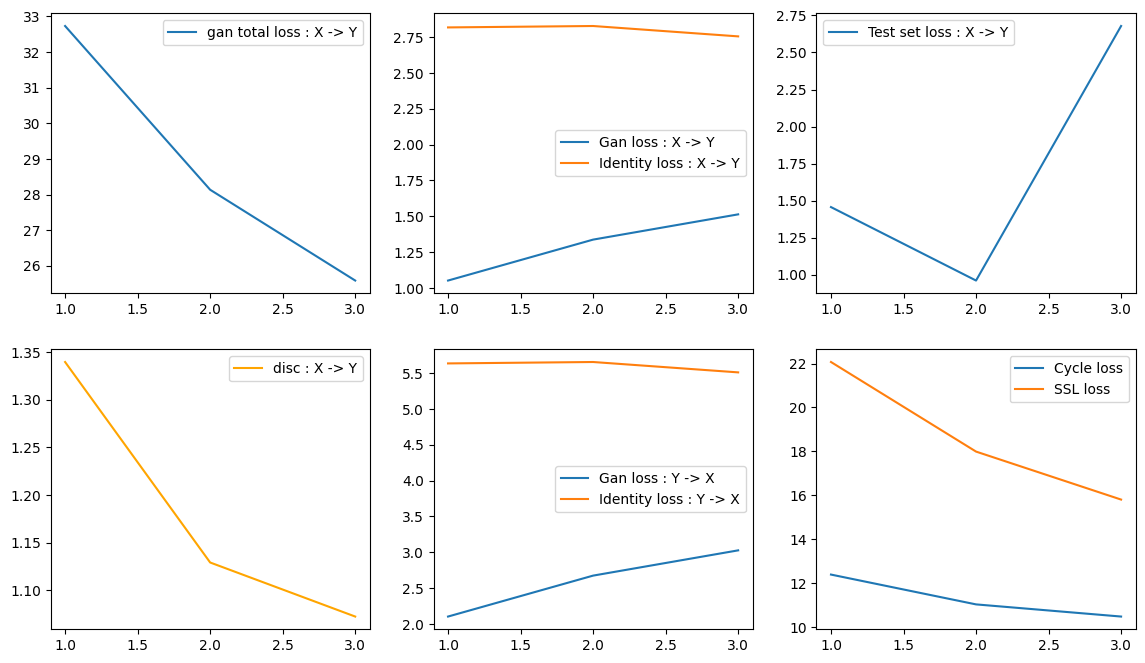

Seed :  7237

Start of epoch 4


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 16963992721683703832
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 11632619973952462886


step 0 gen_loss : 27.194988 disc_loss : 0.64805555 Bright coef : 0.7
step 1 gen_loss : 41.617104 disc_loss : 0.381249 Bright coef : 0.9484888914844757
step 2 gen_loss : 16.061623 disc_loss : 1.543987 Bright coef : 0.8144304742780025
step 3 gen_loss : 23.768356 disc_loss : 0.9779589 Bright coef : 1.0542036985740035
step 4 gen_loss : 17.483917 disc_loss : 2.2353275 Bright coef : 1.037488255807705
step 5 gen_loss : 16.861067 disc_loss : 0.5037424 Bright coef : 1.1
step 6 gen_loss : 27.421799 disc_loss : 0.43381563 Bright coef : 1.1
step 7 gen_loss : 46.968895 disc_loss : 0.4765195 Bright coef : 0.8179755826793901
step 8 gen_loss : 19.102367 disc_loss : 0.89641786 Bright coef : 0.7380540711947186
step 9 gen_loss : 19.07957 disc_loss : 0.699413 Bright coef : 0.9381175133149579
step 10 gen_loss : 39.137424 disc_loss : 0.56924087 Bright coef : 0.9878324128270163
step 11 gen_loss : 43.86825 disc_loss : 0.56619817 Bright coef : 1.1
step 12 gen_loss : 26.277073 disc_loss : 2.046082 Bright coef :

step 104 gen_loss : 32.270317 disc_loss : 1.6327467 Bright coef : 1.089456122922086
step 105 gen_loss : 16.879679 disc_loss : 1.1871412 Bright coef : 0.944462745231504
step 106 gen_loss : 23.88598 disc_loss : 1.2038126 Bright coef : 1.0039285161683793
step 107 gen_loss : 23.942717 disc_loss : 0.26666322 Bright coef : 0.741532393490665
step 108 gen_loss : 20.820053 disc_loss : 0.97384536 Bright coef : 0.7989290354519842
step 109 gen_loss : 17.964212 disc_loss : 0.65216464 Bright coef : 0.8447676103087928
step 110 gen_loss : 47.892834 disc_loss : 1.0459793 Bright coef : 1.1
step 111 gen_loss : 23.93049 disc_loss : 1.0728438 Bright coef : 0.9370907998568844
step 112 gen_loss : 23.562048 disc_loss : 1.1017774 Bright coef : 0.8099619292116045
step 113 gen_loss : 19.197487 disc_loss : 0.36335176 Bright coef : 0.7
step 114 gen_loss : 33.42181 disc_loss : 0.5575177 Bright coef : 0.7
step 115 gen_loss : 38.997078 disc_loss : 1.333287 Bright coef : 1.0811968123406457
step 116 gen_loss : 20.88546

step 206 gen_loss : 42.51444 disc_loss : 0.52105474 Bright coef : 0.7
step 207 gen_loss : 50.231224 disc_loss : 1.3093517 Bright coef : 1.0695581936116332
step 208 gen_loss : 35.780212 disc_loss : 0.44225174 Bright coef : 1.072068402940113
step 209 gen_loss : 17.9868 disc_loss : 2.7375927 Bright coef : 0.8988624482306121
step 210 gen_loss : 25.033888 disc_loss : 0.68824404 Bright coef : 0.7613840960917535
step 211 gen_loss : 33.014206 disc_loss : 0.4839697 Bright coef : 1.1
step 212 gen_loss : 18.64843 disc_loss : 0.5853218 Bright coef : 0.7
step 213 gen_loss : 25.034752 disc_loss : 2.7289972 Bright coef : 1.0699409751815132
step 214 gen_loss : 23.041859 disc_loss : 0.5689815 Bright coef : 0.8275641557028339
step 215 gen_loss : 23.587889 disc_loss : 0.6202749 Bright coef : 0.9114763169170514
step 216 gen_loss : 43.919617 disc_loss : 0.53417534 Bright coef : 1.0083084550970847
step 217 gen_loss : 18.023552 disc_loss : 0.71210706 Bright coef : 1.0591965981049463
step 218 gen_loss : 28.66

step 308 gen_loss : 35.674744 disc_loss : 1.1788845 Bright coef : 1.1
step 309 gen_loss : 19.80096 disc_loss : 1.7380478 Bright coef : 0.7
step 310 gen_loss : 21.67577 disc_loss : 1.1433125 Bright coef : 0.7869153821283865
step 311 gen_loss : 25.216877 disc_loss : 1.4584259 Bright coef : 1.1
step 312 gen_loss : 31.947472 disc_loss : 0.9390558 Bright coef : 0.9931413774123117
step 313 gen_loss : 16.861832 disc_loss : 0.43943626 Bright coef : 0.7468496727018618
step 314 gen_loss : 34.109524 disc_loss : 0.43163717 Bright coef : 0.9250571937226607
step 315 gen_loss : 30.599937 disc_loss : 0.53982943 Bright coef : 1.1
step 316 gen_loss : 21.495138 disc_loss : 1.179299 Bright coef : 0.8821288847263115
step 317 gen_loss : 13.678993 disc_loss : 1.6394523 Bright coef : 0.9058301012794681
step 318 gen_loss : 20.372644 disc_loss : 0.7170192 Bright coef : 0.9639387048044642
step 319 gen_loss : 15.632092 disc_loss : 0.6198155 Bright coef : 0.8598023567365217
step 320 gen_loss : 22.738163 disc_loss 

step 410 gen_loss : 29.99126 disc_loss : 0.53369236 Bright coef : 1.0395500218120404
step 411 gen_loss : 18.469318 disc_loss : 0.6731082 Bright coef : 0.8508119642785826
step 412 gen_loss : 31.230211 disc_loss : 0.854435 Bright coef : 1.1
step 413 gen_loss : 20.479904 disc_loss : 0.6193441 Bright coef : 0.799718153414191
step 414 gen_loss : 26.101324 disc_loss : 1.2544227 Bright coef : 0.905959973937736
step 415 gen_loss : 25.100147 disc_loss : 0.38196412 Bright coef : 0.7282741951661388
step 416 gen_loss : 20.348333 disc_loss : 0.4268099 Bright coef : 0.7836560922631661
step 417 gen_loss : 21.765623 disc_loss : 0.48416817 Bright coef : 0.8717004502624507
step 418 gen_loss : 17.964134 disc_loss : 2.3246605 Bright coef : 0.8102154297034307
step 419 gen_loss : 42.578484 disc_loss : 0.29889703 Bright coef : 1.069806854369129
step 420 gen_loss : 25.914658 disc_loss : 1.7283785 Bright coef : 0.9337571866307582
step 421 gen_loss : 17.183197 disc_loss : 2.1569445 Bright coef : 1.1
step 422 ge

step 512 gen_loss : 19.401985 disc_loss : 0.763137 Bright coef : 1.0084334527176362
step 513 gen_loss : 18.767256 disc_loss : 0.88434386 Bright coef : 0.7
step 514 gen_loss : 16.021202 disc_loss : 0.5579798 Bright coef : 0.8943597885145065
step 515 gen_loss : 31.17269 disc_loss : 0.726588 Bright coef : 0.7
step 516 gen_loss : 27.799273 disc_loss : 0.47180188 Bright coef : 1.0810194240059128
step 517 gen_loss : 33.63365 disc_loss : 0.5109976 Bright coef : 1.0054086832668976
step 518 gen_loss : 22.420078 disc_loss : 1.6743138 Bright coef : 1.0628140319563157
step 519 gen_loss : 21.947273 disc_loss : 0.9097162 Bright coef : 0.8082132106407862
step 520 gen_loss : 26.641485 disc_loss : 0.7858823 Bright coef : 1.1
step 521 gen_loss : 34.101124 disc_loss : 1.8284216 Bright coef : 0.7573562710112435
step 522 gen_loss : 15.866882 disc_loss : 0.8849032 Bright coef : 0.8619834328177483
step 523 gen_loss : 17.91597 disc_loss : 1.2390049 Bright coef : 0.8557828256642644
image_00000087_2.png
image_0

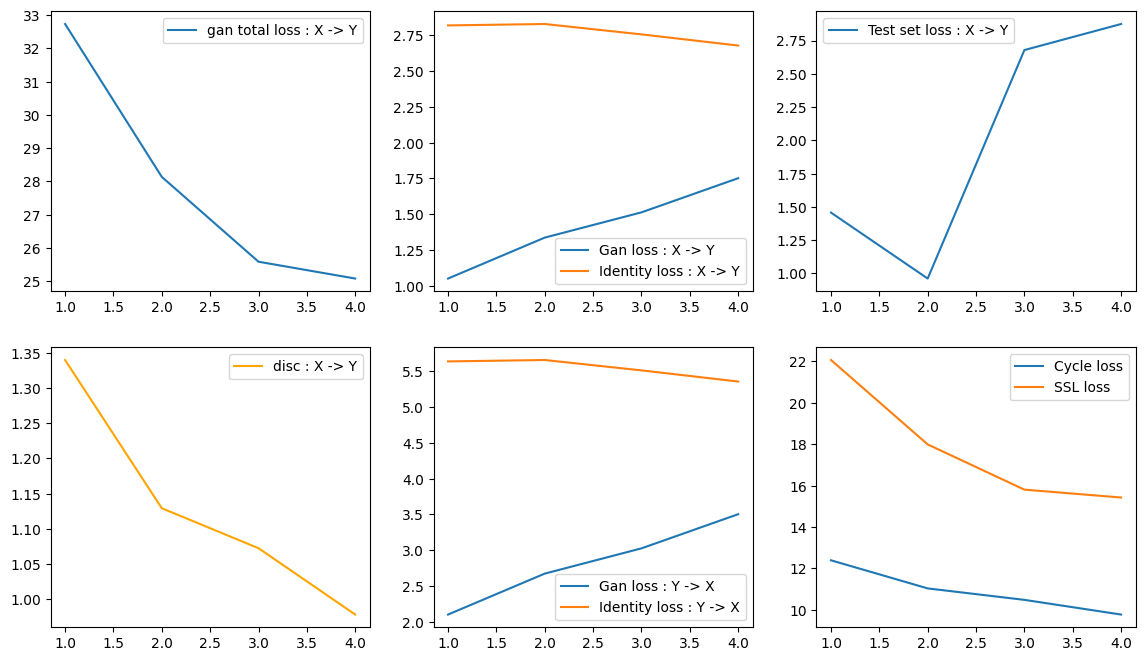

Seed :  99

Start of epoch 5


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 16963992721683703832
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 11632619973952462886


step 0 gen_loss : 26.369534 disc_loss : 0.90731305 Bright coef : 0.8264318888449634
step 1 gen_loss : 27.775803 disc_loss : 2.1379082 Bright coef : 0.9800571495699577
step 2 gen_loss : 13.157055 disc_loss : 1.1285524 Bright coef : 0.7
step 3 gen_loss : 17.130756 disc_loss : 0.94700766 Bright coef : 0.9398640035128129
step 4 gen_loss : 13.624281 disc_loss : 0.7776269 Bright coef : 0.7925101354160071
step 5 gen_loss : 24.884712 disc_loss : 0.6122589 Bright coef : 1.0616086799180489
step 6 gen_loss : 21.209614 disc_loss : 0.9050766 Bright coef : 0.9970646601786456
step 7 gen_loss : 28.655869 disc_loss : 0.91820693 Bright coef : 0.7954021344459401
step 8 gen_loss : 20.329132 disc_loss : 0.8093648 Bright coef : 1.1
step 9 gen_loss : 31.297165 disc_loss : 0.4624082 Bright coef : 1.1
step 10 gen_loss : 15.89724 disc_loss : 0.5144987 Bright coef : 0.8988829310593152
step 11 gen_loss : 15.330787 disc_loss : 1.1163356 Bright coef : 0.7807524505295267
step 12 gen_loss : 25.544165 disc_loss : 1.48

step 104 gen_loss : 24.585653 disc_loss : 1.5505419 Bright coef : 1.1
step 105 gen_loss : 30.47622 disc_loss : 1.2606235 Bright coef : 0.7305511777517683
step 106 gen_loss : 18.890583 disc_loss : 0.29449952 Bright coef : 0.8178545915131699
step 107 gen_loss : 30.663992 disc_loss : 0.9689101 Bright coef : 0.7773271178438841
step 108 gen_loss : 31.085054 disc_loss : 0.48450392 Bright coef : 1.062600431182235
step 109 gen_loss : 14.02063 disc_loss : 1.2416403 Bright coef : 0.7642333930624307
step 110 gen_loss : 29.324759 disc_loss : 0.47204816 Bright coef : 0.9535761152928068
step 111 gen_loss : 55.291077 disc_loss : 0.34751216 Bright coef : 1.0526782582468548
step 112 gen_loss : 40.890884 disc_loss : 0.3087589 Bright coef : 1.1
step 113 gen_loss : 29.294016 disc_loss : 0.41564506 Bright coef : 0.7
step 114 gen_loss : 25.760029 disc_loss : 0.7976022 Bright coef : 1.0549698740847546
step 115 gen_loss : 25.512226 disc_loss : 0.29957882 Bright coef : 0.9209369697900113
step 116 gen_loss : 32

step 208 gen_loss : 16.512619 disc_loss : 0.87988645 Bright coef : 0.838093428400688
step 209 gen_loss : 23.549967 disc_loss : 1.2961016 Bright coef : 0.777363581063399
step 210 gen_loss : 21.239368 disc_loss : 0.9415225 Bright coef : 1.1
step 211 gen_loss : 24.808598 disc_loss : 0.57428277 Bright coef : 1.06260250623124
step 212 gen_loss : 15.995809 disc_loss : 0.48409733 Bright coef : 0.8277077753692813
step 213 gen_loss : 32.57598 disc_loss : 0.4479547 Bright coef : 1.1
step 214 gen_loss : 22.960436 disc_loss : 0.4777133 Bright coef : 1.0343968382092346
step 215 gen_loss : 17.482443 disc_loss : 0.65046287 Bright coef : 0.9687157772842979
step 216 gen_loss : 16.125542 disc_loss : 0.975874 Bright coef : 0.8120703628408867
step 217 gen_loss : 31.851727 disc_loss : 0.8163811 Bright coef : 0.7
step 218 gen_loss : 24.432112 disc_loss : 0.22640753 Bright coef : 0.8003084500035398
step 219 gen_loss : 26.618694 disc_loss : 0.44216767 Bright coef : 0.9286907831940152
step 220 gen_loss : 24.32

step 310 gen_loss : 22.752962 disc_loss : 0.6099688 Bright coef : 1.0301850966267718
step 311 gen_loss : 43.363777 disc_loss : 1.3696591 Bright coef : 1.1
step 312 gen_loss : 15.884436 disc_loss : 1.9030873 Bright coef : 0.8853179951772921
step 313 gen_loss : 47.147224 disc_loss : 1.1004763 Bright coef : 0.7
step 314 gen_loss : 21.551235 disc_loss : 0.3140838 Bright coef : 0.8792033920570469
step 315 gen_loss : 31.23011 disc_loss : 0.37139636 Bright coef : 1.0511556044542871
step 316 gen_loss : 29.973297 disc_loss : 0.46682903 Bright coef : 1.1
step 317 gen_loss : 16.830376 disc_loss : 0.7264174 Bright coef : 0.7691400089593998
step 318 gen_loss : 20.949467 disc_loss : 0.5952822 Bright coef : 0.8869677801122413
step 319 gen_loss : 14.472121 disc_loss : 0.3537767 Bright coef : 0.8728934268464221
step 320 gen_loss : 24.827845 disc_loss : 0.3824035 Bright coef : 0.9182409251395128
step 321 gen_loss : 22.07806 disc_loss : 2.529576 Bright coef : 0.9763738765842699
step 322 gen_loss : 19.907

step 413 gen_loss : 27.718735 disc_loss : 1.1305686 Bright coef : 0.7
step 414 gen_loss : 20.863655 disc_loss : 1.5253853 Bright coef : 1.1
step 415 gen_loss : 17.528893 disc_loss : 0.6221221 Bright coef : 0.8713775910736161
step 416 gen_loss : 27.675694 disc_loss : 0.8037111 Bright coef : 1.1
step 417 gen_loss : 37.101185 disc_loss : 1.1929972 Bright coef : 1.0425690002401573
step 418 gen_loss : 24.690441 disc_loss : 0.55242836 Bright coef : 1.0838113186789133
step 419 gen_loss : 23.68105 disc_loss : 0.8050662 Bright coef : 0.7
step 420 gen_loss : 18.277945 disc_loss : 0.5227006 Bright coef : 0.9487307527215407
step 421 gen_loss : 19.093407 disc_loss : 0.8124604 Bright coef : 0.7
step 422 gen_loss : 29.371792 disc_loss : 0.58689016 Bright coef : 0.7
step 423 gen_loss : 15.88932 disc_loss : 0.53263307 Bright coef : 0.738717347713337
step 424 gen_loss : 38.02751 disc_loss : 0.26626408 Bright coef : 1.1
step 425 gen_loss : 18.161537 disc_loss : 0.5503495 Bright coef : 0.7764717822478907


step 518 gen_loss : 36.98595 disc_loss : 0.24035588 Bright coef : 0.7
step 519 gen_loss : 38.341576 disc_loss : 0.41138375 Bright coef : 1.1
step 520 gen_loss : 11.404453 disc_loss : 1.1658142 Bright coef : 0.9061692143624817
step 521 gen_loss : 34.139538 disc_loss : 0.1907898 Bright coef : 1.093774202814172
step 522 gen_loss : 24.979546 disc_loss : 0.6742756 Bright coef : 0.7
step 523 gen_loss : 58.201813 disc_loss : 1.2335215 Bright coef : 1.1
image_00000087_2.png
image_00000088-3.png
image_00000092-3.png
image_00000092_1.png
image_00000095_2.png
image_00000096-3.png
image_00000099-3.png
image_00000099_1.png
image_00000107-3.png
image_00000108-3.png
image_00000109-3.png
image_00000110-3.png
image_00000117-3.png
image_00000118-3.png
image_00000122-3.png
image_00000123-3.png
image_00000128-3.png
image_00000129-3.png
image_00000134-3.png
image_00000135-3.png
image_00000138-3.png
image_00000139-3.png
image_00000147-3.png
image_00000148-3.png
X :  [1 2 3 4 5]
G :  [32.73222, 28.134443, 25

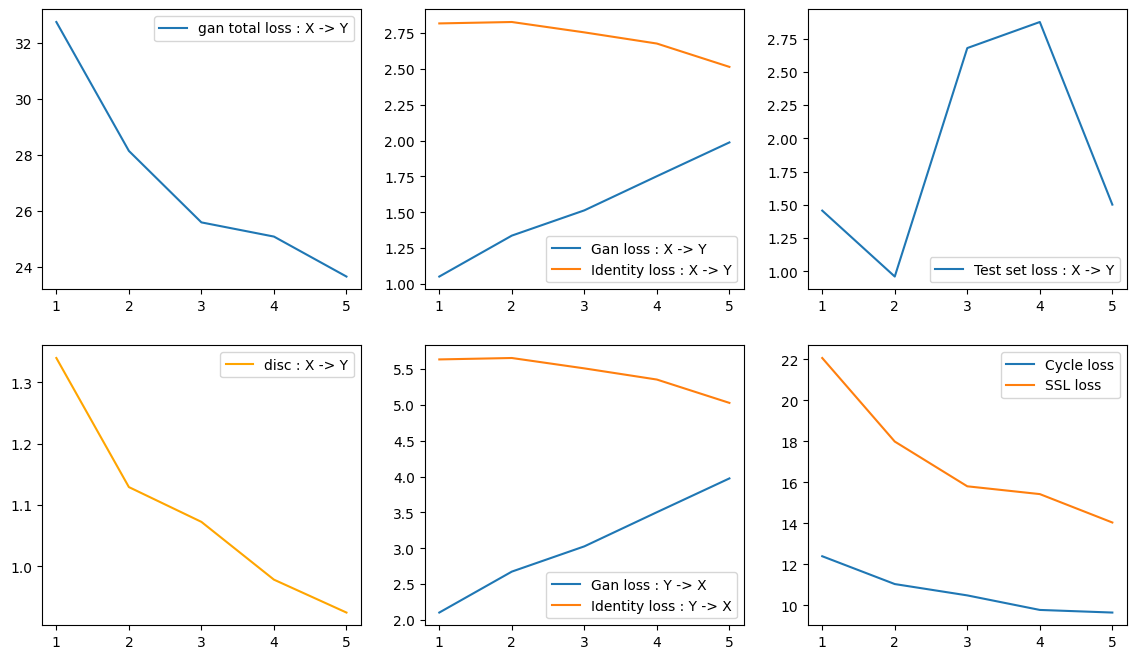

Seed :  1906

Start of epoch 6


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 16963992721683703832
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 11632619973952462886


step 0 gen_loss : 22.623146 disc_loss : 0.52851737 Bright coef : 0.7249073546657194
step 1 gen_loss : 22.67745 disc_loss : 2.1076756 Bright coef : 0.9581274898255185
step 2 gen_loss : 13.915592 disc_loss : 0.7930659 Bright coef : 0.8208668253682699
step 3 gen_loss : 13.623095 disc_loss : 0.37824097 Bright coef : 0.8796467875202367
step 4 gen_loss : 22.095135 disc_loss : 0.8255557 Bright coef : 1.1
step 5 gen_loss : 27.451122 disc_loss : 0.2200558 Bright coef : 1.0430635007867703
step 6 gen_loss : 15.182245 disc_loss : 1.5468714 Bright coef : 0.9160381693724245
step 7 gen_loss : 39.710083 disc_loss : 0.64546925 Bright coef : 0.7
step 8 gen_loss : 12.111454 disc_loss : 1.4626107 Bright coef : 0.7732187086482671
step 9 gen_loss : 33.500175 disc_loss : 0.38703775 Bright coef : 1.0377489265942106
step 10 gen_loss : 19.49355 disc_loss : 0.76215374 Bright coef : 0.7504705176727006
step 11 gen_loss : 18.336666 disc_loss : 0.55912894 Bright coef : 0.8319821992490611
step 12 gen_loss : 21.849684

step 103 gen_loss : 28.32709 disc_loss : 0.46720842 Bright coef : 0.8036936153957768
step 104 gen_loss : 19.768002 disc_loss : 0.2870276 Bright coef : 0.8810441223357265
step 105 gen_loss : 32.699356 disc_loss : 0.70145476 Bright coef : 1.0525766671801802
step 106 gen_loss : 17.723343 disc_loss : 0.48554978 Bright coef : 0.9408754281150844
step 107 gen_loss : 20.738615 disc_loss : 0.63336635 Bright coef : 0.7799750546846739
step 108 gen_loss : 12.30744 disc_loss : 0.9096606 Bright coef : 0.809978282676778
step 109 gen_loss : 33.57625 disc_loss : 0.5169991 Bright coef : 1.0176058590392811
step 110 gen_loss : 25.285583 disc_loss : 0.33128312 Bright coef : 1.1
step 111 gen_loss : 29.27789 disc_loss : 0.7539346 Bright coef : 0.8013148873356569
step 112 gen_loss : 20.21503 disc_loss : 1.0117882 Bright coef : 1.1
step 113 gen_loss : 20.147373 disc_loss : 0.25370628 Bright coef : 0.9481279696551703
step 114 gen_loss : 18.734482 disc_loss : 1.1159315 Bright coef : 1.1
step 115 gen_loss : 27.27

step 206 gen_loss : 22.00422 disc_loss : 0.55970323 Bright coef : 0.7774871861291988
step 207 gen_loss : 29.091423 disc_loss : 1.0120826 Bright coef : 1.0784222806191361
step 208 gen_loss : 24.198063 disc_loss : 1.2746239 Bright coef : 0.7
step 209 gen_loss : 12.987172 disc_loss : 3.4097338 Bright coef : 0.9909964938690058
step 210 gen_loss : 41.934216 disc_loss : 0.45671323 Bright coef : 1.1
step 211 gen_loss : 13.712114 disc_loss : 0.4345699 Bright coef : 0.9045411752665109
step 212 gen_loss : 17.267658 disc_loss : 0.9919753 Bright coef : 0.8330926577468588
step 213 gen_loss : 24.096775 disc_loss : 0.38483533 Bright coef : 0.9362871584734099
step 214 gen_loss : 23.897438 disc_loss : 1.2892265 Bright coef : 0.7
step 215 gen_loss : 35.992634 disc_loss : 0.71780396 Bright coef : 1.0383771279468073
step 216 gen_loss : 14.778214 disc_loss : 1.149525 Bright coef : 1.1
step 217 gen_loss : 20.30623 disc_loss : 0.53512836 Bright coef : 0.9072981363131706
step 218 gen_loss : 22.919523 disc_los

step 309 gen_loss : 23.550194 disc_loss : 1.6477123 Bright coef : 0.8235796171924592
step 310 gen_loss : 26.813034 disc_loss : 0.971091 Bright coef : 1.1
step 311 gen_loss : 23.606342 disc_loss : 0.56179005 Bright coef : 0.7629295460407697
step 312 gen_loss : 11.602517 disc_loss : 1.4007442 Bright coef : 0.7
step 313 gen_loss : 21.642864 disc_loss : 1.5403063 Bright coef : 0.8911652879533125
step 314 gen_loss : 12.294624 disc_loss : 0.633431 Bright coef : 0.8646854820030508
step 315 gen_loss : 21.87946 disc_loss : 0.8929872 Bright coef : 0.7073579718786633
step 316 gen_loss : 27.592304 disc_loss : 0.30027348 Bright coef : 0.9861081487024607
step 317 gen_loss : 46.6359 disc_loss : 1.6946236 Bright coef : 1.1
step 318 gen_loss : 25.858643 disc_loss : 0.38892385 Bright coef : 1.0521998502943184
step 319 gen_loss : 22.648674 disc_loss : 0.90525126 Bright coef : 0.7845926190815145
step 320 gen_loss : 18.2444 disc_loss : 0.41218066 Bright coef : 1.093466166006642
step 321 gen_loss : 14.47384

step 410 gen_loss : 19.036736 disc_loss : 0.8499216 Bright coef : 0.8896167609827412
step 411 gen_loss : 19.256989 disc_loss : 0.92800415 Bright coef : 0.750163309786279
step 412 gen_loss : 21.385767 disc_loss : 0.63120997 Bright coef : 0.9649199378784357
step 413 gen_loss : 27.034903 disc_loss : 0.5346334 Bright coef : 1.1
step 414 gen_loss : 25.030148 disc_loss : 0.50224394 Bright coef : 1.1
step 415 gen_loss : 22.229778 disc_loss : 2.4821758 Bright coef : 0.988876093751274
step 416 gen_loss : 23.436165 disc_loss : 2.6602848 Bright coef : 0.8538069704919065
step 417 gen_loss : 19.630829 disc_loss : 0.49308646 Bright coef : 0.7131040091383358
step 418 gen_loss : 28.442566 disc_loss : 0.9666599 Bright coef : 1.0421860417864368
step 419 gen_loss : 23.426922 disc_loss : 0.9398314 Bright coef : 1.1
step 420 gen_loss : 28.770775 disc_loss : 1.7545322 Bright coef : 0.7
step 421 gen_loss : 22.020248 disc_loss : 1.0988777 Bright coef : 1.1
step 422 gen_loss : 17.479046 disc_loss : 0.37734514 

step 514 gen_loss : 13.59667 disc_loss : 1.1236775 Bright coef : 0.73254246643381
step 515 gen_loss : 15.59335 disc_loss : 0.4995188 Bright coef : 0.7198535907630823
step 516 gen_loss : 22.520773 disc_loss : 0.45214733 Bright coef : 1.0396460896716062
step 517 gen_loss : 20.583462 disc_loss : 0.29645747 Bright coef : 1.1
step 518 gen_loss : 28.548954 disc_loss : 0.34508848 Bright coef : 0.7
step 519 gen_loss : 27.219795 disc_loss : 0.47807056 Bright coef : 0.7
step 520 gen_loss : 17.209095 disc_loss : 1.2738342 Bright coef : 0.7727809316599903
step 521 gen_loss : 22.94683 disc_loss : 0.29250944 Bright coef : 0.8889536620564475
step 522 gen_loss : 23.130102 disc_loss : 0.18018174 Bright coef : 0.7067954843789729
step 523 gen_loss : 28.878448 disc_loss : 1.2116245 Bright coef : 1.048576093056409
image_00000087_2.png
image_00000088-3.png
image_00000092-3.png
image_00000092_1.png
image_00000095_2.png
image_00000096-3.png
image_00000099-3.png
image_00000099_1.png
image_00000107-3.png
image_

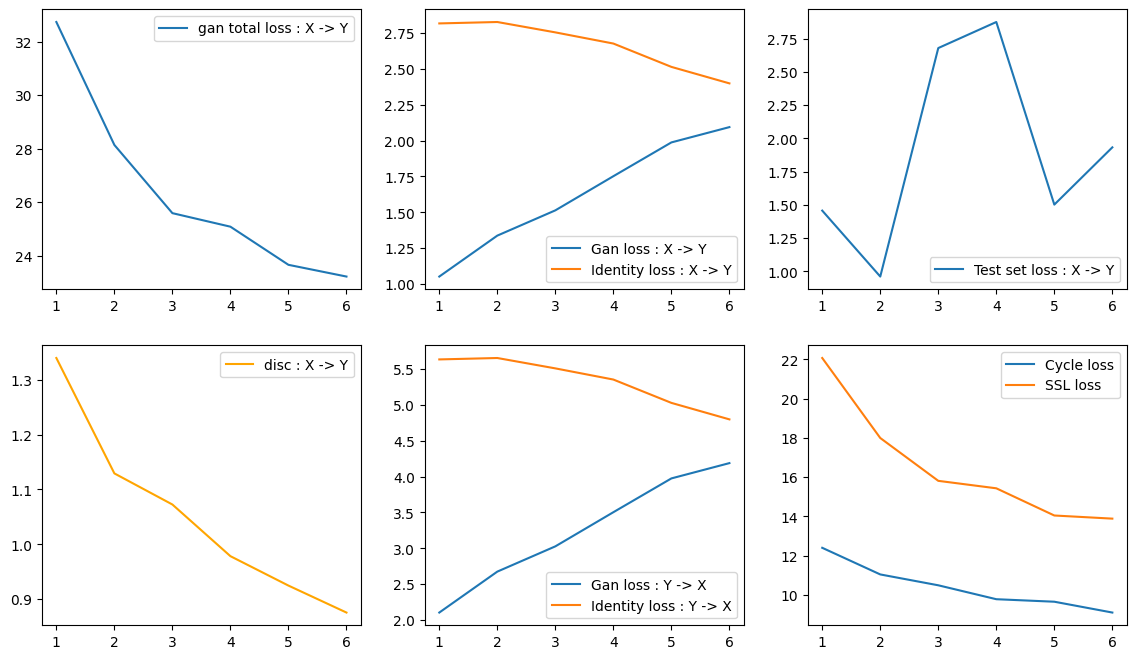

Seed :  7652

Start of epoch 7


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 16963992721683703832
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 11632619973952462886


step 0 gen_loss : 21.527805 disc_loss : 0.90618974 Bright coef : 0.9408969388949001
step 1 gen_loss : 21.172852 disc_loss : 0.89355814 Bright coef : 0.7
step 2 gen_loss : 17.19541 disc_loss : 1.213577 Bright coef : 0.7610207941339662
step 3 gen_loss : 24.00874 disc_loss : 0.27109814 Bright coef : 1.0577463791149204
step 4 gen_loss : 18.894524 disc_loss : 0.3903899 Bright coef : 0.843821820434183
step 5 gen_loss : 41.909927 disc_loss : 0.23981327 Bright coef : 0.8927878136195568
step 6 gen_loss : 23.930199 disc_loss : 1.1684113 Bright coef : 0.8243567798789088
step 7 gen_loss : 21.360554 disc_loss : 0.6498606 Bright coef : 0.7394859149144217
step 8 gen_loss : 18.275887 disc_loss : 0.7955519 Bright coef : 0.7779035916041206
step 9 gen_loss : 17.672472 disc_loss : 0.46925098 Bright coef : 0.9449472538775103
step 10 gen_loss : 14.672697 disc_loss : 1.0061957 Bright coef : 0.9337486250870942
step 11 gen_loss : 29.398323 disc_loss : 1.8348159 Bright coef : 0.8990045824907588
step 12 gen_loss

step 104 gen_loss : 22.36844 disc_loss : 1.4713116 Bright coef : 1.1
step 105 gen_loss : 41.33988 disc_loss : 1.0285032 Bright coef : 1.1
step 106 gen_loss : 17.559177 disc_loss : 1.0195675 Bright coef : 1.1
step 107 gen_loss : 20.374987 disc_loss : 2.0922005 Bright coef : 0.8860684071238929
step 108 gen_loss : 27.793318 disc_loss : 0.4952464 Bright coef : 1.065799401567371
step 109 gen_loss : 15.686294 disc_loss : 1.6785587 Bright coef : 1.1
step 110 gen_loss : 27.174728 disc_loss : 0.9786167 Bright coef : 0.7275756036325604
step 111 gen_loss : 27.733023 disc_loss : 0.5070568 Bright coef : 1.0390162149081077
step 112 gen_loss : 20.220028 disc_loss : 0.6044439 Bright coef : 0.7131841336713898
step 113 gen_loss : 15.614647 disc_loss : 0.7702792 Bright coef : 0.9229183579161273
step 114 gen_loss : 15.614609 disc_loss : 0.39550242 Bright coef : 0.798733362576132
step 115 gen_loss : 33.050392 disc_loss : 0.26022267 Bright coef : 1.057759129116737
step 116 gen_loss : 19.921679 disc_loss : 0

step 206 gen_loss : 35.171516 disc_loss : 0.98830897 Bright coef : 0.7
step 207 gen_loss : 28.680435 disc_loss : 1.383826 Bright coef : 0.9010517814312443
step 208 gen_loss : 18.766857 disc_loss : 2.1473272 Bright coef : 0.7
step 209 gen_loss : 26.623718 disc_loss : 1.4179385 Bright coef : 1.1
step 210 gen_loss : 24.255497 disc_loss : 0.7681101 Bright coef : 0.7498413711268277
step 211 gen_loss : 26.244 disc_loss : 0.46264684 Bright coef : 0.7
step 212 gen_loss : 18.351242 disc_loss : 1.6014345 Bright coef : 0.8329601454090935
step 213 gen_loss : 24.46714 disc_loss : 0.92908823 Bright coef : 1.0457204610498887
step 214 gen_loss : 31.299263 disc_loss : 0.7153985 Bright coef : 1.0051532380355928
step 215 gen_loss : 19.017921 disc_loss : 0.49268126 Bright coef : 1.057837774071552
step 216 gen_loss : 21.26358 disc_loss : 0.26290017 Bright coef : 1.1
step 217 gen_loss : 18.613667 disc_loss : 0.3275734 Bright coef : 0.9593579033110726
step 218 gen_loss : 23.378555 disc_loss : 1.0385092 Brigh

step 309 gen_loss : 23.836918 disc_loss : 2.2007117 Bright coef : 0.9189126797582319
step 310 gen_loss : 23.821812 disc_loss : 1.5407006 Bright coef : 0.9254419893115948
step 311 gen_loss : 16.348465 disc_loss : 0.330299 Bright coef : 0.8881494092134047
step 312 gen_loss : 31.656101 disc_loss : 0.67936903 Bright coef : 0.7
step 313 gen_loss : 15.263453 disc_loss : 1.3397998 Bright coef : 0.8576675917677478
step 314 gen_loss : 14.812989 disc_loss : 1.2963203 Bright coef : 0.7
step 315 gen_loss : 23.671675 disc_loss : 0.5293425 Bright coef : 0.8919903887096363
step 316 gen_loss : 28.137041 disc_loss : 0.48020777 Bright coef : 1.09365617834262
step 317 gen_loss : 15.7458 disc_loss : 1.7140317 Bright coef : 1.0660279667851398
step 318 gen_loss : 16.610722 disc_loss : 0.58670086 Bright coef : 1.1
step 319 gen_loss : 17.288193 disc_loss : 0.4557464 Bright coef : 0.9906097192249099
step 320 gen_loss : 18.399773 disc_loss : 0.73828006 Bright coef : 0.8405066600449083
step 321 gen_loss : 25.353

step 411 gen_loss : 21.193432 disc_loss : 0.50597656 Bright coef : 0.8579025769534067
step 412 gen_loss : 18.340559 disc_loss : 0.38507423 Bright coef : 0.7
step 413 gen_loss : 15.681799 disc_loss : 1.2356491 Bright coef : 0.7645802153421402
step 414 gen_loss : 14.64967 disc_loss : 0.26968023 Bright coef : 0.8580127776138011
step 415 gen_loss : 15.830656 disc_loss : 0.38183314 Bright coef : 0.8079999054264883
step 416 gen_loss : 24.849056 disc_loss : 0.29836679 Bright coef : 1.0892606773937645
step 417 gen_loss : 17.47651 disc_loss : 0.22216655 Bright coef : 0.8655982356266709
step 418 gen_loss : 20.787994 disc_loss : 0.51323384 Bright coef : 0.8992959401807132
step 419 gen_loss : 18.365768 disc_loss : 0.8429708 Bright coef : 0.7163815688665827
step 420 gen_loss : 11.716768 disc_loss : 0.82836163 Bright coef : 0.8432109668167996
step 421 gen_loss : 21.088497 disc_loss : 0.40242088 Bright coef : 0.7
step 422 gen_loss : 18.085175 disc_loss : 1.354548 Bright coef : 1.0813561660783724
step

step 516 gen_loss : 28.682236 disc_loss : 0.41244128 Bright coef : 0.8646396405446259
step 517 gen_loss : 22.404385 disc_loss : 0.4338657 Bright coef : 0.7
step 518 gen_loss : 21.963007 disc_loss : 1.4253389 Bright coef : 0.767471080559212
step 519 gen_loss : 14.525686 disc_loss : 0.83256644 Bright coef : 0.7
step 520 gen_loss : 22.31722 disc_loss : 2.4308472 Bright coef : 0.7
step 521 gen_loss : 16.259045 disc_loss : 0.21970326 Bright coef : 0.8018746174237146
step 522 gen_loss : 12.026593 disc_loss : 0.3976546 Bright coef : 0.8077451493583837
step 523 gen_loss : 52.714405 disc_loss : 1.4460956 Bright coef : 1.1
image_00000087_2.png
image_00000088-3.png
image_00000092-3.png
image_00000092_1.png
image_00000095_2.png
image_00000096-3.png
image_00000099-3.png
image_00000099_1.png
image_00000107-3.png
image_00000108-3.png
image_00000109-3.png
image_00000110-3.png
image_00000117-3.png
image_00000118-3.png
image_00000122-3.png
image_00000123-3.png
image_00000128-3.png
image_00000129-3.png
i

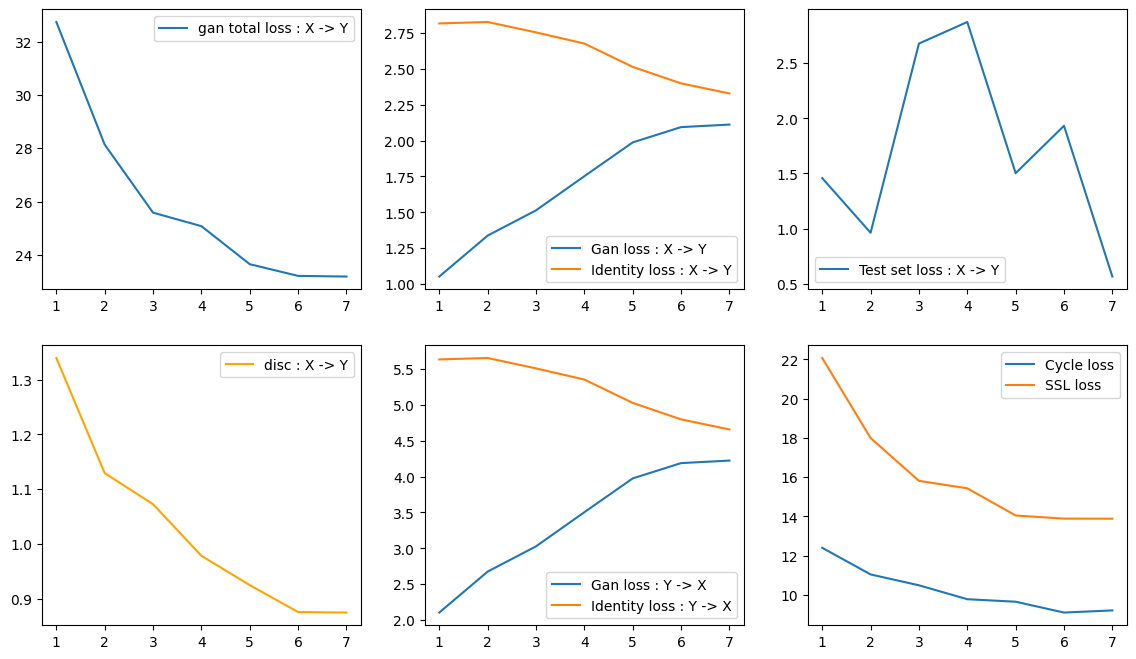

Seed :  2929

Start of epoch 8


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 16963992721683703832
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 11632619973952462886


step 0 gen_loss : 17.96222 disc_loss : 0.3515189 Bright coef : 0.9269582595591317
step 1 gen_loss : 22.611061 disc_loss : 0.39915574 Bright coef : 0.85675416420003
step 2 gen_loss : 13.275605 disc_loss : 0.44637164 Bright coef : 0.9130013171373079
step 3 gen_loss : 16.87054 disc_loss : 0.9559672 Bright coef : 0.7
step 4 gen_loss : 15.053932 disc_loss : 0.5092022 Bright coef : 0.9084642035896545
step 5 gen_loss : 27.099329 disc_loss : 0.2753802 Bright coef : 1.0385627759351352
step 6 gen_loss : 20.181263 disc_loss : 0.54394275 Bright coef : 0.7942333968788375
step 7 gen_loss : 32.315376 disc_loss : 0.45622677 Bright coef : 0.9964929521088889
step 8 gen_loss : 20.65483 disc_loss : 0.3704716 Bright coef : 0.7655209932243239
step 9 gen_loss : 20.590199 disc_loss : 0.78257245 Bright coef : 1.1
step 10 gen_loss : 20.611814 disc_loss : 1.1150703 Bright coef : 0.8144192729221646
step 11 gen_loss : 17.418186 disc_loss : 0.9263019 Bright coef : 0.9879040755730797
step 12 gen_loss : 48.60476 disc

step 104 gen_loss : 21.956318 disc_loss : 0.35703862 Bright coef : 0.8716378394242335
step 105 gen_loss : 13.20972 disc_loss : 0.83448344 Bright coef : 0.7
step 106 gen_loss : 17.384205 disc_loss : 1.0520777 Bright coef : 0.849783611301465
step 107 gen_loss : 19.57173 disc_loss : 0.22186029 Bright coef : 0.8680473898784749
step 108 gen_loss : 15.492595 disc_loss : 0.3172952 Bright coef : 0.879753082010302
step 109 gen_loss : 17.654835 disc_loss : 0.4293611 Bright coef : 0.8690489710153876
step 110 gen_loss : 18.595661 disc_loss : 0.18733674 Bright coef : 0.7
step 111 gen_loss : 22.3615 disc_loss : 0.5455051 Bright coef : 1.0875232604762148
step 112 gen_loss : 25.211958 disc_loss : 0.28328884 Bright coef : 0.9613424719056045
step 113 gen_loss : 18.02903 disc_loss : 0.5487675 Bright coef : 1.0412366255584895
step 114 gen_loss : 14.501255 disc_loss : 0.58208704 Bright coef : 0.9499183537456839
step 115 gen_loss : 18.166706 disc_loss : 0.22358277 Bright coef : 1.0488588270067476
step 116 g

step 208 gen_loss : 13.358139 disc_loss : 1.0561402 Bright coef : 0.7
step 209 gen_loss : 28.09822 disc_loss : 0.7365454 Bright coef : 0.9773373699714981
step 210 gen_loss : 39.00776 disc_loss : 0.8039012 Bright coef : 0.9911772590076198
step 211 gen_loss : 19.12923 disc_loss : 0.53323686 Bright coef : 0.8668717270605107
step 212 gen_loss : 26.904448 disc_loss : 0.49469832 Bright coef : 1.0361696232913864
step 213 gen_loss : 28.820724 disc_loss : 0.76685745 Bright coef : 0.7
step 214 gen_loss : 21.752987 disc_loss : 0.46906418 Bright coef : 1.0182339709663182
step 215 gen_loss : 19.062231 disc_loss : 1.5601552 Bright coef : 1.040500570830024
step 216 gen_loss : 12.499857 disc_loss : 1.2015791 Bright coef : 0.7
step 217 gen_loss : 23.972486 disc_loss : 0.7725849 Bright coef : 0.7175416334061222
step 218 gen_loss : 16.8683 disc_loss : 0.98366344 Bright coef : 1.0431062518584175
step 219 gen_loss : 84.70517 disc_loss : 0.6396414 Bright coef : 1.1
step 220 gen_loss : 25.470205 disc_loss : 

step 310 gen_loss : 16.359798 disc_loss : 0.36934143 Bright coef : 1.1
step 311 gen_loss : 16.402409 disc_loss : 1.1842196 Bright coef : 1.1
step 312 gen_loss : 20.544876 disc_loss : 0.29352766 Bright coef : 1.1
step 313 gen_loss : 25.266985 disc_loss : 0.70438564 Bright coef : 0.7713812465228688
step 314 gen_loss : 18.70341 disc_loss : 0.8848933 Bright coef : 0.9246872347614772
step 315 gen_loss : 16.357672 disc_loss : 0.799273 Bright coef : 0.7593337707687988
step 316 gen_loss : 16.376007 disc_loss : 0.4601902 Bright coef : 0.9422530850268729
step 317 gen_loss : 21.089916 disc_loss : 2.124252 Bright coef : 0.9171384612369003
step 318 gen_loss : 20.783684 disc_loss : 1.4032207 Bright coef : 0.9212493064801391
step 319 gen_loss : 10.40902 disc_loss : 0.9012208 Bright coef : 0.7291477337097658
step 320 gen_loss : 13.0967045 disc_loss : 0.42268747 Bright coef : 0.7904530810593996
step 321 gen_loss : 15.919588 disc_loss : 0.2199868 Bright coef : 0.7
step 322 gen_loss : 39.73268 disc_loss 

step 415 gen_loss : 16.973488 disc_loss : 0.31269962 Bright coef : 0.8289864884036883
step 416 gen_loss : 15.702257 disc_loss : 1.6730579 Bright coef : 0.7
step 417 gen_loss : 20.174103 disc_loss : 0.24790172 Bright coef : 0.8936237297516365
step 418 gen_loss : 26.249277 disc_loss : 0.35825098 Bright coef : 1.0082907742154652
step 419 gen_loss : 30.998497 disc_loss : 0.521214 Bright coef : 0.713992184005994
step 420 gen_loss : 20.813591 disc_loss : 0.4052537 Bright coef : 1.063382714953058
step 421 gen_loss : 14.487539 disc_loss : 0.44475958 Bright coef : 0.8652334827561705
step 422 gen_loss : 13.585762 disc_loss : 0.23775429 Bright coef : 0.8127463638167679
step 423 gen_loss : 20.010742 disc_loss : 1.1147873 Bright coef : 0.7376400394817346
step 424 gen_loss : 14.9941 disc_loss : 0.38323274 Bright coef : 0.7
step 425 gen_loss : 17.60487 disc_loss : 1.4096283 Bright coef : 0.8723871620206677
step 426 gen_loss : 44.726925 disc_loss : 0.11814231 Bright coef : 1.1
step 427 gen_loss : 20.1

step 517 gen_loss : 18.642414 disc_loss : 0.5090177 Bright coef : 0.8470869124063549
step 518 gen_loss : 18.952785 disc_loss : 1.0681397 Bright coef : 1.1
step 519 gen_loss : 14.50078 disc_loss : 0.6427866 Bright coef : 0.9298171873129388
step 520 gen_loss : 36.065727 disc_loss : 0.40806693 Bright coef : 1.0016247339116224
step 521 gen_loss : 19.210052 disc_loss : 0.9557124 Bright coef : 0.9506421015406828
step 522 gen_loss : 20.109514 disc_loss : 0.39173108 Bright coef : 0.8254244511633528
step 523 gen_loss : 34.28724 disc_loss : 0.8860414 Bright coef : 1.1
image_00000087_2.png
image_00000088-3.png
image_00000092-3.png
image_00000092_1.png
image_00000095_2.png
image_00000096-3.png
image_00000099-3.png
image_00000099_1.png
image_00000107-3.png
image_00000108-3.png
image_00000109-3.png
image_00000110-3.png
image_00000117-3.png
image_00000118-3.png
image_00000122-3.png
image_00000123-3.png
image_00000128-3.png
image_00000129-3.png
image_00000134-3.png
image_00000135-3.png
image_00000138-

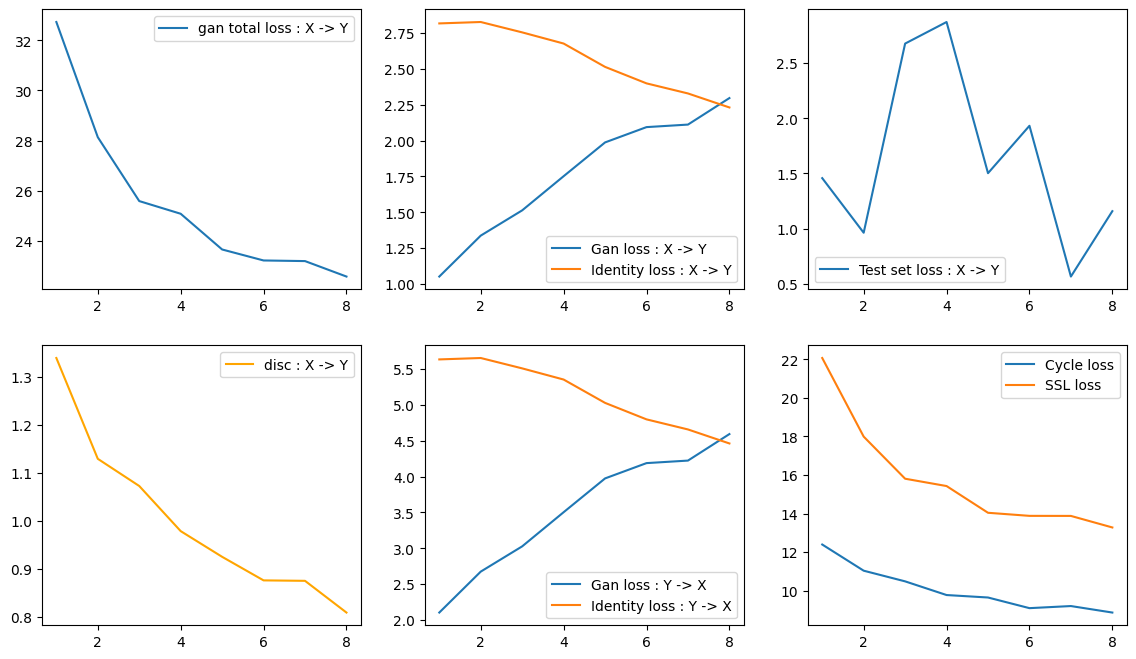

Seed :  9157

Start of epoch 9


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 16963992721683703832
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 11632619973952462886


step 0 gen_loss : 23.34441 disc_loss : 0.48555052 Bright coef : 1.1
step 1 gen_loss : 26.399612 disc_loss : 0.6018883 Bright coef : 0.7896229663686649
step 2 gen_loss : 38.78379 disc_loss : 0.64130324 Bright coef : 0.7
step 3 gen_loss : 21.931223 disc_loss : 0.20320046 Bright coef : 0.7447013205878359
step 4 gen_loss : 23.751831 disc_loss : 1.0420989 Bright coef : 0.8158618394691415
step 5 gen_loss : 25.571964 disc_loss : 0.6197915 Bright coef : 0.9412444603716584
step 6 gen_loss : 25.38609 disc_loss : 1.1749479 Bright coef : 0.9914694491080761
step 7 gen_loss : 20.742863 disc_loss : 0.846274 Bright coef : 1.1
step 8 gen_loss : 20.608107 disc_loss : 1.1387233 Bright coef : 0.7569836749147887
step 9 gen_loss : 26.846962 disc_loss : 1.3960857 Bright coef : 1.0303286412711712
step 10 gen_loss : 25.857225 disc_loss : 0.6386591 Bright coef : 1.0755659896346819
step 11 gen_loss : 26.632616 disc_loss : 0.43399054 Bright coef : 0.877757158494197
step 12 gen_loss : 15.594431 disc_loss : 0.14560

step 103 gen_loss : 12.201313 disc_loss : 0.6880769 Bright coef : 0.7
step 104 gen_loss : 30.171682 disc_loss : 0.19963327 Bright coef : 0.7881335508446946
step 105 gen_loss : 24.888376 disc_loss : 0.9022031 Bright coef : 0.900291608360692
step 106 gen_loss : 13.678194 disc_loss : 0.6254256 Bright coef : 1.0221280575475555
step 107 gen_loss : 21.56949 disc_loss : 0.41074103 Bright coef : 1.059928419850226
step 108 gen_loss : 18.14489 disc_loss : 0.42482924 Bright coef : 0.7660814351380995
step 109 gen_loss : 22.460238 disc_loss : 0.60581297 Bright coef : 0.9689776888966118
step 110 gen_loss : 18.230873 disc_loss : 0.83390355 Bright coef : 0.9488856486188555
step 111 gen_loss : 25.503754 disc_loss : 0.54327464 Bright coef : 1.1
step 112 gen_loss : 20.01835 disc_loss : 0.42728683 Bright coef : 0.9084674655580435
step 113 gen_loss : 19.624105 disc_loss : 0.5153429 Bright coef : 0.9085849151972367
step 114 gen_loss : 22.456514 disc_loss : 0.77604187 Bright coef : 0.7
step 115 gen_loss : 19

step 205 gen_loss : 14.895948 disc_loss : 0.5125052 Bright coef : 0.782600741644676
step 206 gen_loss : 17.026762 disc_loss : 1.6508217 Bright coef : 0.8351516127925936
step 207 gen_loss : 21.035004 disc_loss : 0.8895795 Bright coef : 1.0224708274306022
step 208 gen_loss : 21.260212 disc_loss : 0.5432052 Bright coef : 0.7
step 209 gen_loss : 27.389565 disc_loss : 0.2556396 Bright coef : 1.0096199356285078
step 210 gen_loss : 16.695568 disc_loss : 1.0288876 Bright coef : 0.8403395780657981
step 211 gen_loss : 14.955531 disc_loss : 1.3936268 Bright coef : 0.7
step 212 gen_loss : 16.900944 disc_loss : 1.0998843 Bright coef : 0.7
step 213 gen_loss : 15.59507 disc_loss : 0.42001235 Bright coef : 0.7
step 214 gen_loss : 52.180004 disc_loss : 1.4295201 Bright coef : 1.1
step 215 gen_loss : 16.019547 disc_loss : 1.8616936 Bright coef : 0.7694762648290421
step 216 gen_loss : 25.076307 disc_loss : 0.4320647 Bright coef : 1.0018570222103655
step 217 gen_loss : 17.12906 disc_loss : 0.82702494 Brig

step 308 gen_loss : 12.497053 disc_loss : 0.8113339 Bright coef : 0.8907262685298105
step 309 gen_loss : 13.42692 disc_loss : 1.3812957 Bright coef : 0.9301126045148864
step 310 gen_loss : 20.040325 disc_loss : 0.10508397 Bright coef : 0.9912183226897441
step 311 gen_loss : 16.008993 disc_loss : 1.2459972 Bright coef : 0.7411065721359713
step 312 gen_loss : 20.15749 disc_loss : 0.93288517 Bright coef : 0.9996405351686983
step 313 gen_loss : 21.22081 disc_loss : 1.7605164 Bright coef : 0.8797391992451877
step 314 gen_loss : 15.648584 disc_loss : 0.22658846 Bright coef : 0.9473216392883407
step 315 gen_loss : 14.016808 disc_loss : 1.9222233 Bright coef : 0.9145196075716693
step 316 gen_loss : 20.942541 disc_loss : 0.41784924 Bright coef : 0.9104611720928286
step 317 gen_loss : 34.228798 disc_loss : 0.35278067 Bright coef : 0.7
step 318 gen_loss : 25.897219 disc_loss : 0.67382896 Bright coef : 1.0272198626024773
step 319 gen_loss : 24.648453 disc_loss : 0.18843126 Bright coef : 1.02155266

step 411 gen_loss : 20.247585 disc_loss : 0.4454372 Bright coef : 0.8613712945797534
step 412 gen_loss : 23.434288 disc_loss : 0.32287046 Bright coef : 0.9941057607438909
step 413 gen_loss : 25.931576 disc_loss : 0.6831983 Bright coef : 0.735764276622978
step 414 gen_loss : 31.993052 disc_loss : 0.2892336 Bright coef : 0.7787902685935428
step 415 gen_loss : 16.543127 disc_loss : 0.744695 Bright coef : 0.8926589586406116
step 416 gen_loss : 15.416882 disc_loss : 0.28961262 Bright coef : 0.9923191717679034
step 417 gen_loss : 12.61592 disc_loss : 0.85562617 Bright coef : 0.7
step 418 gen_loss : 21.917488 disc_loss : 1.0309134 Bright coef : 0.8952364767716873
step 419 gen_loss : 25.865189 disc_loss : 0.29999357 Bright coef : 0.7
step 420 gen_loss : 46.579933 disc_loss : 0.9746951 Bright coef : 1.0925178762832555
step 421 gen_loss : 14.877392 disc_loss : 0.62824714 Bright coef : 0.7
step 422 gen_loss : 19.553745 disc_loss : 1.3992597 Bright coef : 0.8708920188747166
step 423 gen_loss : 20.

step 513 gen_loss : 33.089844 disc_loss : 1.3238944 Bright coef : 0.9632175077507328
step 514 gen_loss : 13.044477 disc_loss : 0.24119847 Bright coef : 0.8522076616846711
step 515 gen_loss : 15.565792 disc_loss : 1.3530667 Bright coef : 0.7
step 516 gen_loss : 22.691727 disc_loss : 0.626853 Bright coef : 0.7769432626090518
step 517 gen_loss : 17.704685 disc_loss : 0.40653113 Bright coef : 0.7688529594224021
step 518 gen_loss : 15.789203 disc_loss : 0.24951375 Bright coef : 0.7909737251440062
step 519 gen_loss : 24.861162 disc_loss : 1.3080864 Bright coef : 1.1
step 520 gen_loss : 41.50544 disc_loss : 0.2138003 Bright coef : 1.1
step 521 gen_loss : 28.108936 disc_loss : 1.0589 Bright coef : 0.7
step 522 gen_loss : 24.38387 disc_loss : 0.2052235 Bright coef : 1.1
step 523 gen_loss : 22.637257 disc_loss : 0.23822321 Bright coef : 1.1
image_00000087_2.png
image_00000088-3.png
image_00000092-3.png
image_00000092_1.png
image_00000095_2.png
image_00000096-3.png
image_00000099-3.png
image_0000

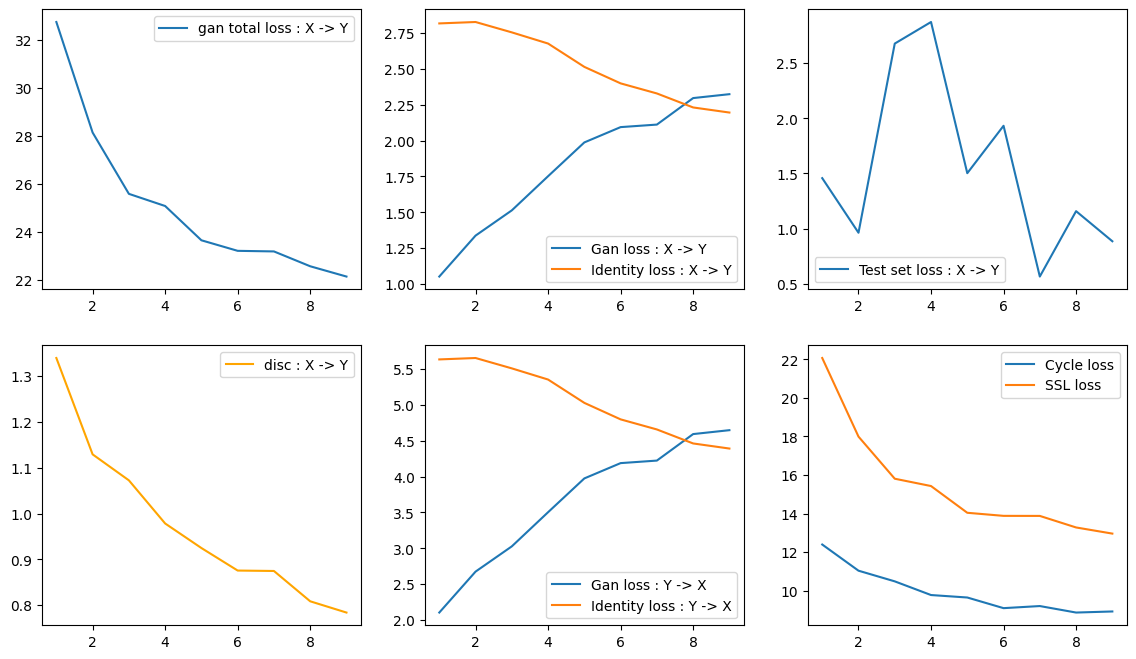

Seed :  5404

Start of epoch 10


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 16963992721683703832
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 11632619973952462886


step 0 gen_loss : 22.440952 disc_loss : 0.9439831 Bright coef : 1.0474489735017676
step 1 gen_loss : 24.042126 disc_loss : 0.49632794 Bright coef : 0.7625715363952278
step 2 gen_loss : 27.538511 disc_loss : 0.86951053 Bright coef : 0.7
step 3 gen_loss : 22.099403 disc_loss : 0.37271404 Bright coef : 0.9605660243785528
step 4 gen_loss : 18.760681 disc_loss : 0.5395621 Bright coef : 0.8203960986784159
step 5 gen_loss : 25.2495 disc_loss : 1.3548825 Bright coef : 0.7
step 6 gen_loss : 21.951351 disc_loss : 0.49515298 Bright coef : 0.7894145630047452
step 7 gen_loss : 65.97084 disc_loss : 2.1015525 Bright coef : 1.1
step 8 gen_loss : 28.610182 disc_loss : 0.64061344 Bright coef : 1.0927438040347546
step 9 gen_loss : 39.155502 disc_loss : 0.40747783 Bright coef : 0.7
step 10 gen_loss : 22.89879 disc_loss : 0.83471495 Bright coef : 1.1
step 11 gen_loss : 28.370787 disc_loss : 0.21425301 Bright coef : 0.9390251325345149
step 12 gen_loss : 27.481836 disc_loss : 0.7348883 Bright coef : 0.896152

step 103 gen_loss : 23.551937 disc_loss : 0.56987673 Bright coef : 0.7
step 104 gen_loss : 36.29154 disc_loss : 1.2368586 Bright coef : 0.9769565073142652
step 105 gen_loss : 21.824286 disc_loss : 1.1232909 Bright coef : 0.8876143173290645
step 106 gen_loss : 20.903667 disc_loss : 1.3291153 Bright coef : 0.7528215952960524
step 107 gen_loss : 16.32996 disc_loss : 0.81024516 Bright coef : 0.7657002095730636
step 108 gen_loss : 25.52874 disc_loss : 0.81211007 Bright coef : 0.9948756428346941
step 109 gen_loss : 18.649782 disc_loss : 0.7466172 Bright coef : 0.9870266770025024
step 110 gen_loss : 25.468779 disc_loss : 0.87942564 Bright coef : 0.8155039592249866
step 111 gen_loss : 14.458727 disc_loss : 0.55992985 Bright coef : 0.8121535237610575
step 112 gen_loss : 29.412003 disc_loss : 1.0485251 Bright coef : 0.8592522130993692
step 113 gen_loss : 12.80167 disc_loss : 0.91898745 Bright coef : 0.7
step 114 gen_loss : 38.11683 disc_loss : 0.58318985 Bright coef : 1.1
step 115 gen_loss : 29.

step 206 gen_loss : 23.876144 disc_loss : 0.1305674 Bright coef : 0.9400275595662784
step 207 gen_loss : 12.468952 disc_loss : 1.1435726 Bright coef : 0.8122242436715109
step 208 gen_loss : 19.263851 disc_loss : 0.34660608 Bright coef : 0.9018261894330731
step 209 gen_loss : 27.32756 disc_loss : 1.9912913 Bright coef : 0.7050447078192019
step 210 gen_loss : 17.081877 disc_loss : 0.20917341 Bright coef : 0.8076279271999018
step 211 gen_loss : 25.378166 disc_loss : 0.82236373 Bright coef : 0.7
step 212 gen_loss : 69.53257 disc_loss : 0.26230383 Bright coef : 1.1
step 213 gen_loss : 51.472702 disc_loss : 1.5113192 Bright coef : 1.0886231646576505
step 214 gen_loss : 20.612469 disc_loss : 0.14566419 Bright coef : 1.049193733562031
step 215 gen_loss : 17.821661 disc_loss : 0.098098226 Bright coef : 1.0788095516970515
step 216 gen_loss : 29.272049 disc_loss : 0.31699556 Bright coef : 0.8805963452572567
step 217 gen_loss : 29.04258 disc_loss : 0.6702966 Bright coef : 0.7
step 218 gen_loss : 1

step 309 gen_loss : 21.580921 disc_loss : 1.4174709 Bright coef : 0.866498380864989
step 310 gen_loss : 21.275875 disc_loss : 0.54512024 Bright coef : 1.1
step 311 gen_loss : 21.045246 disc_loss : 0.5961715 Bright coef : 1.0079443836812572
step 312 gen_loss : 20.43974 disc_loss : 0.7796094 Bright coef : 0.8557920732013875
step 313 gen_loss : 47.544746 disc_loss : 0.16772306 Bright coef : 1.1
step 314 gen_loss : 14.679848 disc_loss : 0.39243436 Bright coef : 0.7858337176425121
step 315 gen_loss : 13.114924 disc_loss : 1.2204257 Bright coef : 0.7
step 316 gen_loss : 28.180304 disc_loss : 0.50974286 Bright coef : 0.8394546510489737
step 317 gen_loss : 30.836926 disc_loss : 1.5566869 Bright coef : 0.9741772008166513
step 318 gen_loss : 22.884562 disc_loss : 0.7174165 Bright coef : 0.7
step 319 gen_loss : 28.29978 disc_loss : 0.857177 Bright coef : 0.7
step 320 gen_loss : 27.264067 disc_loss : 0.34875003 Bright coef : 0.9404254524351983
step 321 gen_loss : 22.15509 disc_loss : 1.0164373 Bri

step 411 gen_loss : 38.00016 disc_loss : 1.0058919 Bright coef : 1.1
step 412 gen_loss : 18.464138 disc_loss : 0.7982613 Bright coef : 1.0893736463959787
step 413 gen_loss : 18.887531 disc_loss : 1.1623154 Bright coef : 1.008935527935052
step 414 gen_loss : 26.383427 disc_loss : 1.2876174 Bright coef : 1.1
step 415 gen_loss : 30.013262 disc_loss : 0.6611735 Bright coef : 0.7
step 416 gen_loss : 27.244692 disc_loss : 0.58353156 Bright coef : 1.1
step 417 gen_loss : 17.884449 disc_loss : 0.34246635 Bright coef : 0.7
step 418 gen_loss : 25.953249 disc_loss : 0.60423326 Bright coef : 1.0294866880789966
step 419 gen_loss : 16.698847 disc_loss : 0.38792226 Bright coef : 0.9901037017563601
step 420 gen_loss : 15.818184 disc_loss : 0.7787529 Bright coef : 0.8108763920723774
step 421 gen_loss : 29.423983 disc_loss : 0.07394004 Bright coef : 0.7
step 422 gen_loss : 17.998993 disc_loss : 0.34850645 Bright coef : 0.8698658909964957
step 423 gen_loss : 17.356506 disc_loss : 1.04974 Bright coef : 0.

step 514 gen_loss : 26.091654 disc_loss : 1.4871584 Bright coef : 0.972810381840507
step 515 gen_loss : 20.982199 disc_loss : 0.20886332 Bright coef : 0.9735478746414798
step 516 gen_loss : 17.987068 disc_loss : 0.43250668 Bright coef : 0.806922040781668
step 517 gen_loss : 21.472687 disc_loss : 0.18350202 Bright coef : 0.7238901902863539
step 518 gen_loss : 17.727837 disc_loss : 0.4598861 Bright coef : 0.9765666006869321
step 519 gen_loss : 36.754814 disc_loss : 0.785141 Bright coef : 1.1
step 520 gen_loss : 14.217809 disc_loss : 0.2707674 Bright coef : 0.8764214721426621
step 521 gen_loss : 18.91762 disc_loss : 1.5652623 Bright coef : 0.8657726807233281
step 522 gen_loss : 29.908613 disc_loss : 0.26683643 Bright coef : 0.7427594208705934
step 523 gen_loss : 23.380236 disc_loss : 0.44396883 Bright coef : 0.9553272652082596
image_00000087_2.png
image_00000088-3.png
image_00000092-3.png
image_00000092_1.png
image_00000095_2.png
image_00000096-3.png
image_00000099-3.png
image_00000099_1.

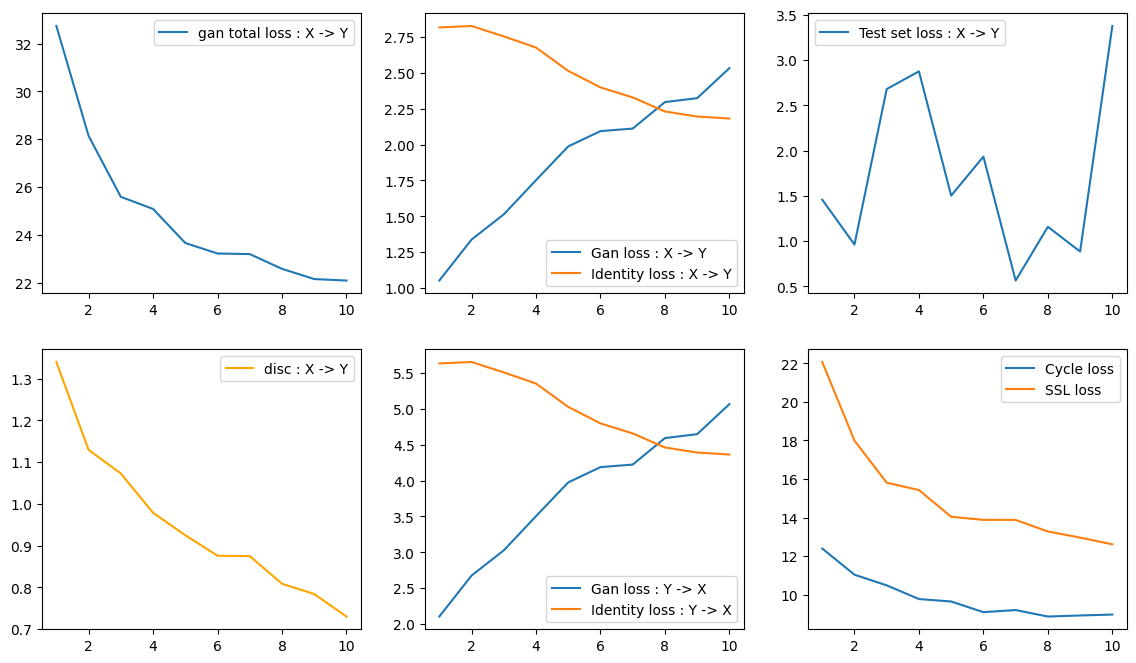

gan_model


In [8]:
# Test Path
path_test = 'test/test_set/test_set_Urban_Launcher_256'
# Save path
save_model = 'save_models/V_Urban_Launcher_Unet/V_SSL/'
save_loss = 'loss/loss_V_Urban_Launcher_Unet/V_SSL/'
#load
#generator.load_weights(save_model+'gen_model_color_epoch_5.h5')
#discriminator.load_weights(save_model+'dis_model_color_epoch_5.h5')

EPOCHS_START=1
EPOCHS = 10
BATCH_SIZE=1
LR_G = 2e-4
LR_D = 2e-4
print("Learning Rate G : "+str(LR_G)+" Learning Rate D : "+str(LR_D))
GEN_X_optimizer = tf.keras.optimizers.Adam(LR_G, beta_1=0.5)    #2e-4
DISC_X_optimizer = tf.keras.optimizers.Adam(LR_D, beta_1=0.5)  #2e-4

GEN_Y_optimizer = tf.keras.optimizers.Adam(LR_G, beta_1=0.5)    #2e-4
DISC_Y_optimizer = tf.keras.optimizers.Adam(LR_D, beta_1=0.5)  #2e-4
#
# Load dataset 
Dataset = tf.data.Dataset.load('./Dataset_wo_sky_256_modif/V_Urban_Launcher/Dataset_VUL')
Dataset_SSL = tf.data.Dataset.load('./Dataset_semi_supervised/V_Urban_Launcher/Dataset_VUL')
#
if EPOCHS_START!=1:
    #load loss
    GLoss_Epochs = list(np.load(save_loss+'Gloss_mean_5.npy')[0:EPOCHS_START])
    DLoss_Epochs = list(np.load(save_loss+'Dloss_mean_5.npy')[0:EPOCHS_START])
    TLoss_Epochs = list(np.load(save_loss+'Tloss_mean_5.npy')[0:EPOCHS_START])
else:
    GLoss_Epochs=[]
    DLoss_Epochs=[]
    TLoss_Epochs=[]
    GANXLoss_Epochs=[]
    GANYLoss_Epochs=[]
    IDXLoss_Epochs=[]
    IDYLoss_Epochs=[]
    CYCLELoss_Epochs=[]
    SSLLoss_Epochs=[]
#
for i in range(EPOCHS_START,EPOCHS+1):
    #
    SEED = random.randint(0,10000)
    print('Seed : ',SEED)
    # SHUFFLE AND BATCH
    Dataset_B = shuffle_and_batch(Dataset, 50, SEED, BATCH_SIZE)
    Dataset_SSL_B = shuffle_and_batch(Dataset_SSL, 50, SEED, 1)
    Dataset_SSL_B = Dataset_SSL_B.repeat(count=8)
    #for j,L in enumerate(Dataset_SSL_B):
    #    print('dataset_'+str(j)+' saved', tf.shape(L))
    #print(j)
    #
    print("\nStart of epoch %d" % (i,))
    #
    # train model
    (D,G, GEN_X, DISC_X, GEN_Y, DISC_Y, GanX, GanY, IdX, IdY, Cycle, SSL_Loss)=train(GEN_X, DISC_X, GEN_Y, DISC_Y, Dataset_B, Dataset_SSL_B, batch=BATCH_SIZE)
    
    GLoss_Epochs.append(np.mean(G))
    DLoss_Epochs.append(np.mean(D))
    GANXLoss_Epochs.append(np.mean(GanX))
    GANYLoss_Epochs.append(np.mean(GanY))
    IDXLoss_Epochs.append(np.mean(IdX))
    IDYLoss_Epochs.append(np.mean(IdY))
    CYCLELoss_Epochs.append(np.mean(Cycle))
    SSLLoss_Epochs.append(np.mean(SSL_Loss))
    
    DISC_X.save_weights(save_model+'disX_model_color_epoch_'+str(i)+'.h5')
    GEN_X.save_weights(save_model+'genX_model_color_epoch_'+str(i)+'.h5')
    DISC_Y.save_weights(save_model+'disY_model_color_epoch_'+str(i)+'.h5')
    GEN_Y.save_weights(save_model+'genY_model_color_epoch_'+str(i)+'.h5')
        
    # test loss
    AVG = test_loss_avg(GEN_X,DISC_Y,path_test)
    TLoss_Epochs.append(AVG)
    # Save loss
    np.save(save_loss+'Dloss_mean_'+str(i)+'.npy',DLoss_Epochs)
    np.save(save_loss+'Gloss_mean_'+str(i)+'.npy',GLoss_Epochs)
    np.save(save_loss+'Tloss_mean_'+str(i)+'.npy',TLoss_Epochs)
    
    X_EPOCHS = np.arange(1,i+1, 1)
    
    print('X : ',X_EPOCHS)
    print('G : ',GLoss_Epochs)
    print('D : ',DLoss_Epochs)
    print('T_avg : ',TLoss_Epochs)

    plt.figure(figsize=(14,8))
    plt.subplot(2, 3, 1)
    plt.plot(X_EPOCHS, GLoss_Epochs, label='gan total loss : X -> Y')
    plt.legend()
    plt.subplot(2, 3, 2)
    plt.plot(X_EPOCHS, GANXLoss_Epochs, label='Gan loss : X -> Y')
    plt.plot(X_EPOCHS, IDXLoss_Epochs, label='Identity loss : X -> Y')
    plt.legend()
    plt.subplot(2, 3, 3)
    plt.plot(X_EPOCHS, np.array(TLoss_Epochs), label='Test set loss : X -> Y')
    plt.legend()
    plt.subplot(2, 3, 4)
    plt.plot(X_EPOCHS, DLoss_Epochs,'orange', label='disc : X -> Y')
    plt.legend()
    plt.subplot(2, 3, 5)
    plt.plot(X_EPOCHS, GANYLoss_Epochs, label='Gan loss : Y -> X')
    plt.plot(X_EPOCHS, IDYLoss_Epochs, label='Identity loss : Y -> X')    
    plt.legend()
    plt.subplot(2, 3, 6)
    plt.plot(X_EPOCHS,CYCLELoss_Epochs, label='Cycle loss')  
    plt.plot(X_EPOCHS,SSLLoss_Epochs, label='SSL loss')
    plt.legend()
    #
    if (i%5 == 0):
        plt.savefig(save_loss+'Loss_'+str(i)+'.png')
        print('Saved')   
    plt.show()             

# save models
print("gan_model")

In [9]:
tf.keras.saving.save_model(DISC_X,'./save_models/V_Urban_Launcher_Unet/V_SSL/save_resnet_DX_5')
tf.keras.saving.save_model(DISC_Y,'./save_models/V_Urban_Launcher_Unet/V_SSL/save_resnet_DY_5')
tf.keras.saving.save_model(GEN_Y,'./save_models/V_Urban_Launcher_Unet/V_SSL/save_resnet_GY_5')
tf.keras.saving.save_model(GEN_X,'./save_models/V_Urban_Launcher_Unet/V_SSL/save_resnet_GX_5')

INFO:tensorflow:Assets written to: ./save_models/V_Urban_Launcher_Unet/V_SSL/save_resnet_DX_5/assets


INFO:tensorflow:Assets written to: ./save_models/V_Urban_Launcher_Unet/V_SSL/save_resnet_DX_5/assets


INFO:tensorflow:Assets written to: ./save_models/V_Urban_Launcher_Unet/V_SSL/save_resnet_DY_5/assets


INFO:tensorflow:Assets written to: ./save_models/V_Urban_Launcher_Unet/V_SSL/save_resnet_DY_5/assets


INFO:tensorflow:Assets written to: ./save_models/V_Urban_Launcher_Unet/V_SSL/save_resnet_GY_5/assets


INFO:tensorflow:Assets written to: ./save_models/V_Urban_Launcher_Unet/V_SSL/save_resnet_GY_5/assets


INFO:tensorflow:Assets written to: ./save_models/V_Urban_Launcher_Unet/V_SSL/save_resnet_GX_5/assets


INFO:tensorflow:Assets written to: ./save_models/V_Urban_Launcher_Unet/V_SSL/save_resnet_GX_5/assets


In [15]:
# try on a test image
import cv2
from tensorflow import keras
import numpy as np

save_models = 'save_models/V_Urban_Launcher_Unet/V_SSL/'
image_shape=(1024,1024,3)

num = 4

# define the models
generator = define_generator(image_shape)
# load initial weights
generator.load_weights(save_models+'genX_model_color_epoch_'+str(num)+'.h5') #4,5,13,25
#generator = tf.keras.saving.load_model('./save_models/V_Urban_Launcher_Unet/V_SSL/save_resnet_GX')

if ('gen_'+str(num)) not in os.listdir('test/val_set/V_Urban_Launcher_Unet/V_SSL'):
    os.mkdir('test/val_set/V_Urban_Launcher_Unet/V_SSL/gen_'+str(num))

doss_image = 'test/val_set/org_1024'
doss_gen = 'test/val_set/V_Urban_Launcher_Unet/V_SSL/gen_'+str(num)  #V17/gen_50'
#doss_image ='dataset_color_transfer/test_sans_batch/V5_dts/new'
#doss_gen = 'dataset_color_transfer/test_sans_batch/V5_dts/old'

IMAGE=os.listdir(doss_image)
IMAGE.sort()

for file in IMAGE:
    old = os.path.join(doss_image,file)
    new = os.path.join(doss_gen,file+'_CGAN_'+str(num)+'.jpg') 
    #new = os.path.join(doss_gen,file) 
    X1=[]
    # now read the input image files (difference from the code it is derived from that preloads all images)
    pixels = Image.open(old).convert("RGB")
    pixels = np.array(pixels)
    #dim=(256,256)
    #pixels = cv2.resize(pixels, dim)
    pixels = pixels[np.newaxis, ...]
    #
    img_fake = generator(pixels, training=False)
    #print(tf.shape(img_fake))
    img_fake = img_fake[0].numpy() * 127.5 + 127.5#127.5
    img_fake= img_fake.astype(np.uint8)   #(np.uint8)
    print(img_fake)
    dim=(512,512)
    img_fake = cv2.cvtColor(img_fake, cv2.COLOR_RGB2BGR)
    resized_2 = cv2.resize(img_fake, dim)
    #image_reco=Image.fromarray(resized_2)
    #image_reco.show()
    cv2.imwrite(new,resized_2)
    #image_reco = image_reco.save(new)

(6, 2, 2)
Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 1024, 1024, 3)]      0         []                            
                                                                                                  
 tf.compat.v1.pad_27 (TFOpL  (None, 1026, 1026, 3)        0         ['input_12[0][0]']            
 ambda)                                                                                           
                                                                                                  
 encoder_block_0 (Conv2D)    (None, 1024, 1024, 32)       896       ['tf.compat.v1.pad_27[0][0]'] 
                                                                                                  
 batch_normalization_98 (Ba  (None, 1024, 1024, 32)       128       ['encoder_blo

 e)                                                                 ]',                           
                                                                     'leaky_re_lu_57[0][0]']      
                                                                                                  
 activation_68 (Activation)  (None, 256, 256, 256)        0         ['concatenate_47[0][0]']      
                                                                                                  
 decoder_block_1 (Conv2DTra  (None, 512, 512, 64)         147520    ['activation_68[0][0]']       
 nspose)                                                                                          
                                                                                                  
 batch_normalization_106 (B  (None, 512, 512, 64)         256       ['decoder_block_1[0][0]']     
 atchNormalization)                                                                               
          

[[[227 249 253]
  [222 249 253]
  [220 248 253]
  ...
  [228 245 250]
  [233 247 250]
  [236 248 251]]

 [[226 249 253]
  [219 248 253]
  [220 248 253]
  ...
  [226 245 250]
  [233 247 250]
  [235 248 251]]

 [[225 249 253]
  [221 249 253]
  [216 247 253]
  ...
  [228 245 250]
  [232 247 250]
  [235 248 251]]

 ...

 [[ 51  30  31]
  [ 45  28  29]
  [ 46  31  30]
  ...
  [204 193 115]
  [207 200 114]
  [207 202 123]]

 [[ 46  31  31]
  [ 42  30  29]
  [ 43  33  33]
  ...
  [205 197 120]
  [205 201 119]
  [212 204 128]]

 [[ 53  35  35]
  [ 47  30  32]
  [ 50  35  34]
  ...
  [198 186 112]
  [200 197 115]
  [204 201 126]]]
[[[215 246 252]
  [211 246 252]
  [208 245 251]
  ...
  [205 235 247]
  [207 237 248]
  [213 240 249]]

 [[215 245 252]
  [208 244 251]
  [210 244 251]
  ...
  [201 235 247]
  [209 237 247]
  [211 239 249]]

 [[213 245 252]
  [211 245 252]
  [203 244 251]
  ...
  [205 236 247]
  [206 237 248]
  [214 240 249]]

 ...

 [[ 84  70  52]
  [ 67  62  46]
  [ 87  83  65]
  ..

[[[217 243 251]
  [213 243 251]
  [209 241 251]
  ...
  [210 240 250]
  [213 240 250]
  [219 243 251]]

 [[216 242 251]
  [212 241 251]
  [210 240 250]
  ...
  [206 239 249]
  [213 241 249]
  [216 242 250]]

 [[215 242 251]
  [214 242 251]
  [205 240 250]
  ...
  [209 240 249]
  [209 241 250]
  [217 242 250]]

 ...

 [[ 80  59  51]
  [ 76  55  50]
  [ 89  63  57]
  ...
  [113  68  54]
  [117  72  54]
  [114  76  61]]

 [[ 79  64  52]
  [ 81  62  52]
  [ 88  68  59]
  ...
  [115  67  54]
  [112  72  56]
  [123  76  60]]

 [[ 80  63  53]
  [ 80  57  53]
  [ 94  67  58]
  ...
  [105  61  50]
  [103  68  53]
  [110  73  59]]]
[[[214 244 251]
  [210 243 250]
  [208 242 250]
  ...
  [205 240 251]
  [206 242 251]
  [211 243 252]]

 [[214 243 251]
  [208 242 250]
  [209 241 249]
  ...
  [200 239 250]
  [206 241 250]
  [207 243 251]]

 [[211 242 250]
  [209 242 250]
  [204 241 249]
  ...
  [204 240 250]
  [201 241 251]
  [211 243 251]]

 ...

 [[133 107  56]
  [129 102  55]
  [131 109  59]
  ..

In [19]:
# try on a test image
import cv2
from tensorflow import keras
import numpy as np

save_models = 'save_models/V_Urban_Launcher_Unet/V_SSL/'
image_shape=(1024,1024,3)

num = 3

# define the models
generator = define_generator(image_shape)
#load initial weights
generator.load_weights(save_models+'genY_model_color_epoch_'+str(num)+'.h5') #4,5,13,25

doss_image = 'test/val_set/V_Urban_Launcher_Unet/V_SSL/img_Urban_new'
doss_gen = 'test/val_set/V_Urban_Launcher_Unet/V_SSL/img_Urban_old_3'  #V17/gen_50'
#doss_image ='dataset_color_transfer/test_sans_batch/V5_dts/new'
#doss_gen = 'dataset_color_transfer/test_sans_batch/V5_dts/old'

IMAGE=os.listdir(doss_image)
IMAGE.sort()

for file in IMAGE:
    old = os.path.join(doss_image,file)
    new = os.path.join(doss_gen,file) 
    #new = os.path.join(doss_gen,file) 
    X1=[]
    # now read the input image files (difference from the code it is derived from that preloads all images)
    pixels = Image.open(old).convert("RGB")
    pixels = np.array(pixels)
    dim=(1024,1024)
    resized_1 = cv2.resize(pixels, dim)
    resized_1 = resized_1[np.newaxis, ...]
    #
    img_fake = generator(resized_1, training=False)
    img_fake = img_fake[0].numpy() * 127.5 + 127.5
    img_fake= img_fake.astype(np.uint8)
    dim=(512,512)
    resized_2 = cv2.resize(img_fake, dim)
    print(resized_2)
    image_reco=Image.fromarray(resized_2)
    image_reco = image_reco.save(new)

(6, 2, 2)
Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 1024, 1024, 3)]      0         []                            
                                                                                                  
 tf.compat.v1.pad_39 (TFOpL  (None, 1026, 1026, 3)        0         ['input_16[0][0]']            
 ambda)                                                                                           
                                                                                                  
 encoder_block_0 (Conv2D)    (None, 1024, 1024, 32)       896       ['tf.compat.v1.pad_39[0][0]'] 
                                                                                                  
 batch_normalization_138 (B  (None, 1024, 1024, 32)       128       ['encoder_blo

 e)                                                                 ]',                           
                                                                     'leaky_re_lu_77[0][0]']      
                                                                                                  
 activation_96 (Activation)  (None, 256, 256, 256)        0         ['concatenate_67[0][0]']      
                                                                                                  
 decoder_block_1 (Conv2DTra  (None, 512, 512, 64)         147520    ['activation_96[0][0]']       
 nspose)                                                                                          
                                                                                                  
 batch_normalization_146 (B  (None, 512, 512, 64)         256       ['decoder_block_1[0][0]']     
 atchNormalization)                                                                               
          

[[[211 225 230]
  [187 203 208]
  [216 214 223]
  ...
  [ 55  60  56]
  [ 74  82  97]
  [ 66  71  92]]

 [[221 235 241]
  [231 241 246]
  [236 237 242]
  ...
  [ 52  58  62]
  [ 55  56  65]
  [ 73  71  93]]

 [[225 235 237]
  [237 241 242]
  [237 232 236]
  ...
  [ 81  91 112]
  [ 60  55  71]
  [ 67  60  89]]

 ...

 [[182 152 140]
  [199 174 169]
  [221 209 215]
  ...
  [ 99 111 128]
  [ 54  58  64]
  [ 88  91 101]]

 [[200 174 173]
  [192 170 163]
  [209 190 193]
  ...
  [149 141 164]
  [124 126 131]
  [130 117 135]]

 [[202 180 184]
  [198 177 174]
  [201 179 176]
  ...
  [150 147 146]
  [161 149 155]
  [138 126 132]]]
[[[115 114 102]
  [135 131 125]
  [146 139 143]
  ...
  [206 236 239]
  [241 248 252]
  [235 245 250]]

 [[130 126 120]
  [135 135 138]
  [170 170 180]
  ...
  [235 246 248]
  [234 241 248]
  [138 175 190]]

 [[133 130 126]
  [163 165 165]
  [180 180 186]
  ...
  [242 247 251]
  [125 150 174]
  [ 45  66  82]]

 ...

 [[232 237 241]
  [222 222 228]
  [211 197 204]
  ..

[[[209 192 197]
  [204 191 192]
  [208 191 196]
  ...
  [141 160 177]
  [140 162 178]
  [140 163 178]]

 [[210 194 197]
  [208 193 198]
  [189 175 179]
  ...
  [144 161 178]
  [144 166 178]
  [145 169 179]]

 [[223 201 205]
  [212 192 196]
  [212 201 204]
  ...
  [146 156 172]
  [159 180 195]
  [169 188 211]]

 ...

 [[233 247 250]
  [241 249 251]
  [230 246 248]
  ...
  [186 175 171]
  [186 171 173]
  [199 180 183]]

 [[245 251 253]
  [245 251 253]
  [246 252 253]
  ...
  [182 162 166]
  [190 168 169]
  [198 173 178]]

 [[249 253 254]
  [247 253 254]
  [249 253 254]
  ...
  [174 156 150]
  [182 156 152]
  [190 166 167]]]
[[[215 189 196]
  [209 182 186]
  [208 187 192]
  ...
  [178 139 177]
  [174 144 174]
  [158 138 155]]

 [[218 195 203]
  [205 180 183]
  [207 185 190]
  ...
  [220 201 219]
  [186 161 175]
  [166 147 157]]

 [[210 184 192]
  [208 187 194]
  [212 191 196]
  ...
  [157 137 151]
  [163 156 161]
  [166 157 167]]

 ...

 [[188 195 198]
  [192 196 200]
  [186 194 196]
  ..

[[[ 78 105 108]
  [ 52  69  65]
  [ 57  71  71]
  ...
  [118  88  99]
  [147 119 135]
  [158 137 154]]

 [[ 75  88  96]
  [ 63  71  73]
  [ 59  66  71]
  ...
  [163 144 151]
  [179 159 169]
  [175 158 167]]

 [[101  85 100]
  [102  84 100]
  [ 87  72  94]
  ...
  [164 142 150]
  [152 134 134]
  [148 129 133]]

 ...

 [[198 215 223]
  [195 212 220]
  [206 220 225]
  ...
  [176 204 199]
  [181 206 209]
  [181 206 205]]

 [[210 221 230]
  [185 195 205]
  [148 158 171]
  ...
  [174 199 201]
  [182 204 209]
  [185 204 209]]

 [[221 230 238]
  [195 201 214]
  [127 132 151]
  ...
  [163 191 188]
  [175 198 201]
  [183 205 208]]]
[[[230 225 239]
  [218 219 233]
  [228 229 243]
  ...
  [233 242 245]
  [222 237 241]
  [210 232 238]]

 [[228 227 239]
  [229 233 243]
  [242 244 250]
  ...
  [217 230 242]
  [217 229 237]
  [193 216 224]]

 [[233 238 245]
  [240 245 249]
  [246 249 252]
  ...
  [245 249 253]
  [224 235 241]
  [184 206 217]]

 ...

 [[197 141 152]
  [184 124 134]
  [181 117 125]
  ..

[[[245 248 251]
  [244 248 251]
  [244 248 251]
  ...
  [246 249 251]
  [246 249 251]
  [246 249 251]]

 [[244 248 251]
  [244 248 251]
  [245 248 251]
  ...
  [246 249 251]
  [246 249 251]
  [246 249 251]]

 [[244 248 251]
  [244 248 251]
  [245 248 251]
  ...
  [246 249 252]
  [246 249 251]
  [246 249 251]]

 ...

 [[131 116 127]
  [136 117 129]
  [137 118 130]
  ...
  [ 90  93 109]
  [ 91  94 120]
  [ 91  94 115]]

 [[126 113 123]
  [132 114 126]
  [134 117 129]
  ...
  [ 92  91 116]
  [ 92  93 117]
  [ 91  90 114]]

 [[123 115 122]
  [125 113 122]
  [130 116 126]
  ...
  [ 89  91 107]
  [ 89  91 108]
  [ 86  89 106]]]
[[[244 248 251]
  [244 249 251]
  [246 250 252]
  ...
  [138 106 101]
  [142 113 108]
  [141 109 105]]

 [[246 250 252]
  [246 250 252]
  [248 251 253]
  ...
  [150 112 108]
  [152 117 110]
  [151 114 108]]

 [[248 251 253]
  [248 251 253]
  [248 251 253]
  ...
  [150 111 113]
  [154 118 115]
  [158 117 117]]

 ...

 [[ 80  90 101]
  [ 80  88 101]
  [ 81  91 101]
  ..

[[[112 118 112]
  [125 138 138]
  [133 148 159]
  ...
  [ 97 117 144]
  [ 90 108 140]
  [ 81  97 127]]

 [[164 176 195]
  [167 177 193]
  [135 146 160]
  ...
  [ 93 112 142]
  [ 87 106 135]
  [ 82  99 129]]

 [[235 242 247]
  [225 230 240]
  [175 184 199]
  ...
  [ 68  84 122]
  [ 68  82 115]
  [ 73  83 122]]

 ...

 [[133 144 141]
  [140 151 167]
  [166 174 189]
  ...
  [ 48  45  56]
  [ 55  53  77]
  [ 56  55  76]]

 [[154 165 173]
  [184 204 216]
  [220 224 236]
  ...
  [ 58  50  74]
  [ 64  56  82]
  [ 66  55  85]]

 [[175 197 203]
  [219 233 240]
  [229 229 239]
  ...
  [ 58  52  68]
  [ 64  55  73]
  [ 65  57  79]]]
[[[246 252 253]
  [247 252 253]
  [247 252 253]
  ...
  [250 253 254]
  [249 253 254]
  [250 253 254]]

 [[246 252 253]
  [247 252 253]
  [247 252 253]
  ...
  [250 253 254]
  [250 253 254]
  [250 253 254]]

 [[246 252 253]
  [247 252 253]
  [248 252 253]
  ...
  [250 253 254]
  [250 253 254]
  [250 253 254]]

 ...

 [[ 64  83  59]
  [ 71  73  56]
  [ 91  98  97]
  ..

[[[253 254 254]
  [253 254 254]
  [253 254 254]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 [[253 254 254]
  [253 254 254]
  [253 254 254]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 [[253 254 254]
  [253 254 254]
  [253 254 254]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 ...

 [[ 69  90  64]
  [ 57  77  50]
  [ 64  88  57]
  ...
  [ 42  34  45]
  [ 66  62  85]
  [ 71  71  92]]

 [[ 45  63  44]
  [ 48  75  45]
  [ 63  87  56]
  ...
  [ 47  36  54]
  [ 72  67  94]
  [ 73  65  95]]

 [[ 51  73  51]
  [ 55  86  58]
  [ 48  67  41]
  ...
  [ 51  41  52]
  [ 75  69  90]
  [ 70  64  87]]]
[[[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 ...

 [[ 76  83  83]
  [ 80  83  87]
  [ 74  88  94]
  ..

[[[252 254 254]
  [252 254 254]
  [252 254 254]
  ...
  [249 253 254]
  [249 253 254]
  [249 253 254]]

 [[252 254 254]
  [252 254 254]
  [252 254 254]
  ...
  [249 253 254]
  [249 253 254]
  [250 253 254]]

 [[252 253 254]
  [252 254 254]
  [252 254 254]
  ...
  [249 253 254]
  [250 253 254]
  [249 253 254]]

 ...

 [[ 99  82  90]
  [103  92 107]
  [ 76  71  80]
  ...
  [142 135 105]
  [145 136 117]
  [156 141 124]]

 [[ 93  80  93]
  [ 63  53  68]
  [ 56  55  60]
  ...
  [152 142 124]
  [149 139 125]
  [158 139 132]]

 [[ 85  79  88]
  [ 97  87  93]
  [105  95 102]
  ...
  [156 151 129]
  [161 150 136]
  [174 160 153]]]
[[[213 231 243]
  [213 231 243]
  [213 231 243]
  ...
  [219 236 246]
  [220 236 247]
  [221 237 247]]

 [[213 230 243]
  [213 230 243]
  [214 231 243]
  ...
  [221 236 246]
  [221 236 246]
  [223 236 246]]

 [[213 230 243]
  [214 231 244]
  [215 231 244]
  ...
  [222 237 248]
  [222 237 247]
  [222 236 247]]

 ...

 [[115  90 111]
  [108  83 106]
  [109  94 111]
  ..

[[[247 251 253]
  [247 251 253]
  [247 252 253]
  ...
  [249 252 254]
  [249 252 254]
  [249 252 254]]

 [[247 251 253]
  [247 251 253]
  [248 251 253]
  ...
  [249 252 254]
  [249 252 254]
  [249 252 254]]

 [[247 251 253]
  [247 251 253]
  [248 252 253]
  ...
  [249 252 254]
  [249 252 254]
  [249 252 254]]

 ...

 [[110  85  88]
  [117  91 100]
  [112  86  88]
  ...
  [ 39  39  51]
  [ 39  43  60]
  [ 43  44  59]]

 [[126  96 101]
  [118  87  94]
  [121  95  97]
  ...
  [ 51  44  72]
  [ 48  45  69]
  [ 43  37  60]]

 [[125 101 104]
  [114  86  90]
  [143 115 119]
  ...
  [ 49  43  62]
  [ 49  43  60]
  [ 45  38  55]]]
[[[247 251 253]
  [246 251 253]
  [247 252 253]
  ...
  [249 252 254]
  [249 252 254]
  [249 252 254]]

 [[247 251 253]
  [247 251 253]
  [248 251 253]
  ...
  [249 252 254]
  [249 252 254]
  [249 252 254]]

 [[247 251 253]
  [247 251 253]
  [248 252 253]
  ...
  [249 252 254]
  [249 252 254]
  [249 252 254]]

 ...

 [[110  85  88]
  [118  91 100]
  [112  86  88]
  ..

[[[215 227 239]
  [214 227 239]
  [213 227 239]
  ...
  [219 230 242]
  [220 231 242]
  [222 232 243]]

 [[215 226 239]
  [214 226 238]
  [214 226 238]
  ...
  [220 230 242]
  [221 230 242]
  [222 232 242]]

 [[215 226 239]
  [214 226 238]
  [214 226 238]
  ...
  [220 231 243]
  [221 232 242]
  [223 231 243]]

 ...

 [[181 161 164]
  [180 158 161]
  [176 156 159]
  ...
  [221 205 209]
  [224 207 215]
  [227 209 217]]

 [[179 159 161]
  [176 156 159]
  [174 155 156]
  ...
  [221 201 211]
  [224 206 215]
  [227 207 217]]

 [[178 160 163]
  [174 156 159]
  [172 155 157]
  ...
  [221 204 212]
  [224 207 215]
  [228 210 219]]]
[[[247 252 253]
  [247 252 253]
  [247 252 253]
  ...
  [248 252 253]
  [248 252 253]
  [248 252 253]]

 [[247 251 253]
  [247 252 253]
  [248 252 253]
  ...
  [248 252 253]
  [249 252 253]
  [249 252 253]]

 [[248 251 253]
  [248 252 253]
  [249 252 253]
  ...
  [249 252 253]
  [249 252 253]
  [248 252 253]]

 ...

 [[ 77 100  67]
  [ 98 124  88]
  [ 82 112  75]
  ..

[[[226 242 251]
  [226 242 251]
  [226 243 251]
  ...
  [ 71  65 110]
  [ 77  77 132]
  [ 75  72 125]]

 [[225 241 251]
  [225 242 251]
  [226 242 251]
  ...
  [ 68  61 103]
  [ 73  70 120]
  [ 72  67 119]]

 [[225 241 251]
  [226 242 251]
  [227 242 251]
  ...
  [ 68  58 107]
  [ 79  70 123]
  [ 81  70 128]]

 ...

 [[218 211 217]
  [217 208 216]
  [217 208 214]
  ...
  [ 71  88  65]
  [ 91 107  89]
  [111 119 104]]

 [[221 213 221]
  [220 212 219]
  [218 209 217]
  ...
  [ 49  64  54]
  [ 56  74  60]
  [ 61  75  64]]

 [[224 219 226]
  [223 217 224]
  [221 213 221]
  ...
  [ 63  73  64]
  [ 56  70  57]
  [ 53  70  58]]]
[[[102  88  83]
  [106  91  85]
  [110  95  89]
  ...
  [189 170 214]
  [171 143 203]
  [161 130 196]]

 [[107  93  86]
  [110  94  88]
  [112  97  90]
  ...
  [156 132 188]
  [151 123 184]
  [147 116 182]]

 [[116 100  94]
  [116 100  94]
  [113  97  89]
  ...
  [143 118 182]
  [140 109 176]
  [134  99 171]]

 ...

 [[ 44  80  52]
  [ 45  81  53]
  [ 49  89  61]
  ..

[[[234 227 232]
  [238 232 237]
  [226 220 228]
  ...
  [209 194 213]
  [133 120 146]
  [ 80  70  84]]

 [[192 179 181]
  [228 222 226]
  [237 232 241]
  ...
  [182 160 187]
  [ 97  83 103]
  [ 97  76  91]]

 [[141 130 116]
  [180 178 173]
  [233 227 232]
  ...
  [111  91 118]
  [ 82  66  74]
  [118  92 110]]

 ...

 [[218 222 228]
  [217 220 228]
  [217 221 226]
  ...
  [ 73  74  91]
  [ 73  76  99]
  [ 73  76  94]]

 [[220 223 231]
  [218 221 228]
  [216 220 227]
  ...
  [ 80  76 102]
  [ 79  77 101]
  [ 78  72  97]]

 [[223 227 233]
  [220 224 231]
  [218 223 229]
  ...
  [ 78  77  95]
  [ 80  77  94]
  [ 77  73  93]]]
[[[123 150 144]
  [136 163 159]
  [154 176 176]
  ...
  [253 254 254]
  [253 254 254]
  [253 254 254]]

 [[ 97 121 115]
  [110 136 130]
  [133 159 153]
  ...
  [253 254 254]
  [253 254 254]
  [253 254 254]]

 [[ 40  65  57]
  [ 50  77  66]
  [ 74 105  93]
  ...
  [253 254 254]
  [253 254 254]
  [253 254 254]]

 ...

 [[ 38  71  41]
  [ 34  61  34]
  [ 43  72  43]
  ..

[[[ 79  98  85]
  [ 79  97  86]
  [ 76  92  82]
  ...
  [220 161 165]
  [220 163 165]
  [221 164 169]]

 [[ 82  99  88]
  [ 81  98  89]
  [ 80  95  85]
  ...
  [219 159 161]
  [220 163 161]
  [221 162 166]]

 [[ 89 102  95]
  [ 88 101  95]
  [ 87  98  91]
  ...
  [219 158 163]
  [218 162 162]
  [220 161 167]]

 ...

 [[138 152 147]
  [144 156 154]
  [151 163 162]
  ...
  [159 151 140]
  [161 153 151]
  [161 152 146]]

 [[140 154 151]
  [144 157 156]
  [152 165 164]
  ...
  [136 126 120]
  [143 134 128]
  [143 130 125]]

 [[142 157 154]
  [146 160 158]
  [152 166 166]
  ...
  [123 118 103]
  [131 122 111]
  [130 122 111]]]
[[[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [233 243 249]
  [246 250 253]
  [250 252 253]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [245 250 252]
  [248 252 253]
  [250 252 253]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [249 251 253]
  [249 251 253]
  [249 251 253]]

 ...

 [[ 49  44  90]
  [ 46  40  90]
  [ 43  43  85]
  ..

[[[105  95 103]
  [105  94 109]
  [ 87  76  96]
  ...
  [168 153 156]
  [175 163 167]
  [182 169 176]]

 [[108  97 106]
  [106  95 111]
  [ 85  77  96]
  ...
  [168 152 155]
  [174 159 161]
  [178 162 166]]

 [[109  96 105]
  [108  94 111]
  [ 88  76  96]
  ...
  [170 152 159]
  [173 158 158]
  [175 156 162]]

 ...

 [[ 86  91  99]
  [ 88  93 102]
  [ 88  94 102]
  ...
  [200 211 213]
  [193 207 213]
  [199 210 214]]

 [[ 81  88  93]
  [ 81  88  95]
  [ 79  87  94]
  ...
  [204 211 221]
  [196 208 216]
  [199 206 215]]

 [[ 80  90  93]
  [ 76  86  91]
  [ 72  80  85]
  ...
  [208 216 223]
  [199 209 217]
  [198 207 215]]]
[[[233 239 243]
  [234 240 244]
  [237 242 246]
  ...
  [ 78  78  83]
  [ 75  78  83]
  [ 76  78  84]]

 [[233 239 243]
  [234 240 244]
  [237 242 246]
  ...
  [ 78  76  80]
  [ 75  78  79]
  [ 76  77  80]]

 [[234 239 244]
  [235 240 244]
  [237 242 246]
  ...
  [ 74  75  81]
  [ 74  77  79]
  [ 75  74  81]]

 ...

 [[133 101 107]
  [135 100 109]
  [136  99 109]
  ..

[[[152 118 120]
  [161 126 130]
  [159 126 131]
  ...
  [244 245 249]
  [245 245 249]
  [245 245 249]]

 [[154 119 121]
  [163 127 132]
  [164 129 133]
  ...
  [244 245 249]
  [245 245 249]
  [244 245 248]]

 [[155 118 119]
  [167 129 134]
  [173 135 141]
  ...
  [245 245 249]
  [245 245 249]
  [245 245 249]]

 ...

 [[135 150 158]
  [139 153 163]
  [146 161 169]
  ...
  [ 42  51  82]
  [ 49  61  98]
  [ 52  64 100]]

 [[117 134 142]
  [120 136 145]
  [127 143 151]
  ...
  [ 52  53 101]
  [ 55  59 105]
  [ 53  55 102]]

 [[ 95 113 123]
  [ 96 114 125]
  [104 120 130]
  ...
  [ 46  49  88]
  [ 51  53  92]
  [ 48  48  90]]]
[[[238 243 247]
  [238 243 247]
  [238 244 247]
  ...
  [ 78  71  74]
  [ 76  73  75]
  [ 80  76  80]]

 [[238 243 247]
  [238 243 247]
  [239 243 247]
  ...
  [ 75  70  70]
  [ 76  75  72]
  [ 79  74  76]]

 [[238 243 247]
  [238 243 247]
  [240 244 248]
  ...
  [ 75  72  76]
  [ 77  75  76]
  [ 76  69  76]]

 ...

 [[233 238 243]
  [234 238 243]
  [235 239 244]
  ..

[[[152 135 156]
  [171 164 183]
  [210 217 230]
  ...
  [116 154 164]
  [158 197 204]
  [187 210 219]]

 [[191 190 206]
  [197 203 214]
  [223 227 236]
  ...
  [114 150 159]
  [157 195 202]
  [187 209 217]]

 [[217 209 217]
  [211 206 212]
  [221 210 217]
  ...
  [112 147 161]
  [155 195 201]
  [187 207 217]]

 ...

 [[ 76  83  94]
  [ 87  94 107]
  [ 98 105 122]
  ...
  [207 214 218]
  [210 215 222]
  [210 215 221]]

 [[140 150 167]
  [153 165 185]
  [173 187 207]
  ...
  [214 219 228]
  [218 222 230]
  [217 221 229]]

 [[166 181 192]
  [178 196 207]
  [200 215 226]
  ...
  [219 226 232]
  [225 228 235]
  [224 228 235]]]
[[[ 34  46  49]
  [ 45  61  62]
  [ 60  86  86]
  ...
  [ 72 107 148]
  [ 67 105 139]
  [ 68 108 143]]

 [[ 36  53  52]
  [ 41  61  60]
  [ 48  80  76]
  ...
  [ 72 105 144]
  [ 65 107 137]
  [ 65 106 138]]

 [[ 36  53  58]
  [ 37  54  60]
  [ 40  62  67]
  ...
  [ 73 108 152]
  [ 68 108 141]
  [ 66 106 141]]

 ...

 [[206 208 214]
  [209 210 217]
  [214 211 220]
  ..

[[[ 42  79  68]
  [ 46  79  69]
  [ 59  87  78]
  ...
  [252 253 254]
  [252 253 254]
  [252 253 254]]

 [[ 20  44  37]
  [ 22  47  41]
  [ 35  66  53]
  ...
  [252 253 254]
  [252 253 254]
  [252 253 254]]

 [[ 19  36  40]
  [ 20  37  41]
  [ 23  42  42]
  ...
  [253 253 254]
  [252 253 254]
  [252 253 254]]

 ...

 [[164 176 173]
  [175 187 189]
  [176 190 191]
  ...
  [161 193 205]
  [164 198 212]
  [173 202 215]]

 [[107 124 122]
  [102 115 116]
  [108 125 125]
  ...
  [168 197 213]
  [171 199 215]
  [175 200 216]]

 [[ 71  96  91]
  [ 90 113 102]
  [130 151 146]
  ...
  [171 200 214]
  [173 200 215]
  [174 200 215]]]
[[[159 173 176]
  [184 200 204]
  [211 217 223]
  ...
  [ 80  92 108]
  [ 46  69  82]
  [ 29  43  51]]

 [[175 181 184]
  [162 171 169]
  [159 164 161]
  ...
  [ 65  75  91]
  [ 37  60  68]
  [ 25  37  42]]

 [[173 175 180]
  [145 147 153]
  [122 127 127]
  ...
  [ 79  88 107]
  [ 46  66  81]
  [ 29  40  50]]

 ...

 [[ 78  75  92]
  [ 80  77  95]
  [ 76  78  91]
  ..

[[[191 183 158]
  [194 188 166]
  [136 134 101]
  ...
  [241 248 252]
  [241 249 252]
  [242 249 252]]

 [[156 152 115]
  [158 162 129]
  [134 140 104]
  ...
  [242 249 252]
  [242 249 252]
  [243 249 252]]

 [[114 126  82]
  [140 156 115]
  [ 96 115  72]
  ...
  [243 249 252]
  [243 249 252]
  [243 249 252]]

 ...

 [[ 61  66  84]
  [ 34  39  56]
  [ 23  33  39]
  ...
  [112 108 101]
  [110 104 105]
  [118 112 105]]

 [[ 30  33  53]
  [ 33  33  55]
  [ 41  36  58]
  ...
  [117 108 112]
  [111  98 101]
  [113  99  99]]

 [[ 43  39  60]
  [ 39  34  58]
  [ 42  36  52]
  ...
  [112 104 100]
  [110  96  94]
  [108  96  92]]]
[[[ 85  97  82]
  [ 89  99  86]
  [ 88  99  87]
  ...
  [ 76  93  64]
  [ 76  94  66]
  [ 75  92  65]]

 [[ 87  99  85]
  [ 89 100  88]
  [ 90 100  88]
  ...
  [ 74  91  61]
  [ 74  95  62]
  [ 74  91  62]]

 [[ 88  98  84]
  [ 91  99  88]
  [ 91 100  86]
  ...
  [ 71  89  62]
  [ 73  95  64]
  [ 73  89  64]]

 ...

 [[104 110 141]
  [103 108 140]
  [103 112 140]
  ..

[[[158 166 186]
  [222 236 243]
  [249 251 253]
  ...
  [201 156 166]
  [200 159 169]
  [201 158 172]]

 [[146 150 169]
  [212 226 234]
  [246 246 250]
  ...
  [202 156 165]
  [201 158 167]
  [200 157 167]]

 [[137 130 144]
  [191 193 205]
  [223 212 224]
  ...
  [203 158 172]
  [201 162 170]
  [200 156 169]]

 ...

 [[245 248 250]
  [245 248 250]
  [246 248 250]
  ...
  [110 168 146]
  [112 172 155]
  [122 175 158]]

 [[234 238 241]
  [235 240 242]
  [238 241 244]
  ...
  [125 179 169]
  [121 178 165]
  [124 174 163]]

 [[221 228 233]
  [224 232 236]
  [229 235 239]
  ...
  [134 187 176]
  [124 178 166]
  [121 173 160]]]
[[[146 104 104]
  [150 107 108]
  [151 107 110]
  ...
  [204 180 185]
  [178 154 151]
  [162 132 127]]

 [[136  95  96]
  [136  95  97]
  [136  94  96]
  ...
  [212 189 202]
  [195 170 173]
  [171 142 133]]

 [[127  83  87]
  [128  84  87]
  [126  82  86]
  ...
  [229 215 227]
  [215 195 201]
  [176 145 143]]

 ...

 [[103  97 104]
  [ 94  85  96]
  [ 85  79  89]
  ..

[[[248 251 253]
  [248 251 253]
  [249 252 253]
  ...
  [242 249 252]
  [243 249 252]
  [242 249 252]]

 [[248 251 253]
  [248 251 253]
  [249 251 253]
  ...
  [243 249 252]
  [243 249 252]
  [243 249 251]]

 [[249 251 253]
  [248 251 253]
  [249 251 253]
  ...
  [243 249 252]
  [243 249 252]
  [243 249 252]]

 ...

 [[ 72  89  67]
  [ 98 109  94]
  [109 113 113]
  ...
  [ 64  76  74]
  [ 66  77  86]
  [ 66  76  83]]

 [[ 79  89  74]
  [ 83  90  79]
  [ 83  89  87]
  ...
  [ 69  71  86]
  [ 69  72  89]
  [ 70  66  86]]

 [[ 94  98  89]
  [ 94  96  90]
  [ 93  95  94]
  ...
  [ 66  69  78]
  [ 69  67  79]
  [ 66  64  79]]]
[[[234 238 243]
  [233 237 242]
  [233 237 243]
  ...
  [242 244 249]
  [241 244 249]
  [242 245 249]]

 [[233 237 243]
  [233 237 242]
  [233 237 242]
  ...
  [242 244 249]
  [242 244 249]
  [242 245 249]]

 [[234 238 243]
  [234 237 243]
  [235 238 243]
  ...
  [243 245 249]
  [242 245 249]
  [242 245 249]]

 ...

 [[ 57  57  76]
  [ 65  72  90]
  [ 92 120 135]
  ..

[[[251 252 253]
  [251 252 253]
  [251 252 253]
  ...
  [250 252 253]
  [250 252 253]
  [250 252 253]]

 [[251 252 253]
  [251 252 253]
  [252 252 254]
  ...
  [250 252 253]
  [250 252 253]
  [250 252 253]]

 [[251 252 253]
  [251 252 254]
  [252 253 254]
  ...
  [250 252 253]
  [250 252 253]
  [250 252 253]]

 ...

 [[ 80  84  82]
  [ 76  82  83]
  [ 67  87  82]
  ...
  [122 116 101]
  [120 114 108]
  [120 114 101]]

 [[ 77  81  80]
  [ 69  79  78]
  [ 62  82  77]
  ...
  [132 122 119]
  [129 120 116]
  [124 112 107]]

 [[ 78  83  82]
  [ 72  81  80]
  [ 65  80  76]
  ...
  [132 124 116]
  [130 118 112]
  [122 114 105]]]
[[[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [221 237 244]
  [233 243 247]
  [233 243 247]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [229 241 246]
  [224 233 237]
  [212 219 221]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [214 223 230]
  [192 194 195]
  [183 174 174]]

 ...

 [[ 78  85 118]
  [ 79  84 121]
  [ 79  85 120]
  ..

[[[220 226 232]
  [217 224 230]
  [221 225 232]
  ...
  [216 187 202]
  [209 180 192]
  [211 182 196]]

 [[221 226 232]
  [219 224 231]
  [221 224 231]
  ...
  [210 177 192]
  [208 176 190]
  [210 181 194]]

 [[224 226 233]
  [221 224 231]
  [223 223 231]
  ...
  [204 170 185]
  [208 179 189]
  [208 176 190]]

 ...

 [[ 68  70  93]
  [ 67  67  92]
  [ 68  73  93]
  ...
  [ 93  98  97]
  [ 95  99 103]
  [ 98 101 102]]

 [[ 62  60  87]
  [ 66  63  90]
  [ 69  66  91]
  ...
  [100  99 110]
  [104 102 110]
  [106 102 109]]

 [[ 69  69  90]
  [ 72  70  93]
  [ 72  66  86]
  ...
  [100 100 105]
  [102  99 104]
  [100  98 103]]]
[[[227 241 251]
  [225 242 251]
  [226 243 251]
  ...
  [197 199 207]
  [198 201 208]
  [200 202 210]]

 [[226 241 251]
  [225 241 250]
  [226 242 251]
  ...
  [197 197 205]
  [199 200 206]
  [200 200 207]]

 [[226 241 251]
  [226 242 251]
  [227 242 251]
  ...
  [196 195 205]
  [198 198 204]
  [199 196 206]]

 ...

 [[ 85  76 102]
  [ 81  74 102]
  [ 77  77  99]
  ..

[[[209 221 227]
  [210 222 227]
  [210 222 228]
  ...
  [103 131 168]
  [105 132 168]
  [108 134 173]]

 [[209 221 227]
  [210 222 228]
  [211 222 228]
  ...
  [124 173 206]
  [125 174 207]
  [127 175 209]]

 [[210 222 227]
  [211 222 228]
  [212 223 228]
  ...
  [134 199 224]
  [137 200 223]
  [137 199 225]]

 ...

 [[ 73  80  60]
  [ 79  83  67]
  [ 79  86  71]
  ...
  [ 48  57  64]
  [ 47  58  74]
  [ 47  56  67]]

 [[ 83  85  70]
  [ 83  88  70]
  [ 81  86  68]
  ...
  [ 61  59  84]
  [ 58  63  82]
  [ 54  54  74]]

 [[ 88  91  78]
  [ 86  90  76]
  [ 86  88  72]
  ...
  [ 58  60  71]
  [ 59  61  70]
  [ 54  56  66]]]
[[[236 249 252]
  [236 249 252]
  [236 249 252]
  ...
  [ 88  95  97]
  [ 77  82  83]
  [ 78  80  83]]

 [[236 249 252]
  [236 249 252]
  [236 249 252]
  ...
  [ 91  96  98]
  [ 82  84  84]
  [ 80  79  82]]

 [[236 249 252]
  [236 249 252]
  [237 250 252]
  ...
  [ 84  89  93]
  [ 86  90  89]
  [ 85  84  90]]

 ...

 [[169 142 142]
  [169 139 141]
  [158 132 129]
  ..

[[[203 194 203]
  [181 163 171]
  [128 111 116]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 [[202 190 201]
  [177 158 167]
  [126 110 114]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 [[198 185 196]
  [174 154 162]
  [130 111 115]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 ...

 [[234 223 231]
  [234 221 230]
  [233 222 230]
  ...
  [ 72  74  71]
  [ 70  74  81]
  [ 70  75  75]]

 [[233 221 231]
  [233 221 229]
  [232 220 229]
  ...
  [ 76  75  82]
  [ 75  76  83]
  [ 73  71  77]]

 [[234 224 232]
  [233 223 231]
  [233 221 230]
  ...
  [ 77  79  77]
  [ 77  75  77]
  [ 70  72  70]]]
[[[ 40  58  37]
  [ 42  62  39]
  [ 42  64  41]
  ...
  [243 250 252]
  [243 250 252]
  [244 250 253]]

 [[ 38  55  35]
  [ 37  55  34]
  [ 35  53  33]
  ...
  [251 254 254]
  [251 254 254]
  [251 254 254]]

 [[ 39  55  37]
  [ 38  55  36]
  [ 37  54  36]
  ...
  [253 254 254]
  [253 254 254]
  [253 254 254]]

 ...

 [[ 53  57  55]
  [ 53  55  56]
  [ 52  58  57]
  ..

[[[ 95 187 243]
  [ 98 186 243]
  [ 96 188 243]
  ...
  [ 95 145 194]
  [ 45 100 177]
  [ 46 105 187]]

 [[201 248 254]
  [199 248 254]
  [201 248 254]
  ...
  [ 95 145 194]
  [ 44 107 175]
  [ 53 112 190]]

 [[229 254 254]
  [229 254 254]
  [231 254 254]
  ...
  [115 163 210]
  [131 178 235]
  [160 203 248]]

 ...

 [[231 236 239]
  [231 236 240]
  [232 237 240]
  ...
  [189 206 194]
  [251 254 254]
  [254 254 254]]

 [[232 236 240]
  [231 236 239]
  [232 236 239]
  ...
  [186 200 201]
  [252 254 254]
  [254 254 254]]

 [[233 238 242]
  [231 238 241]
  [232 237 241]
  ...
  [187 203 201]
  [252 254 254]
  [254 254 254]]]
[[[245 253 254]
  [244 253 254]
  [243 253 254]
  ...
  [ 61  55  52]
  [ 73  69  91]
  [ 72  64  94]]

 [[238 251 253]
  [234 250 252]
  [234 249 252]
  ...
  [ 63  55  52]
  [ 73  68  87]
  [ 73  62  90]]

 [[227 245 249]
  [207 238 245]
  [223 246 250]
  ...
  [ 64  59  56]
  [ 77  70  90]
  [ 74  61  94]]

 ...

 [[126 138 135]
  [128 135 135]
  [128 138 136]
  ..

[[[252 254 254]
  [252 254 254]
  [252 254 254]
  ...
  [130  89  71]
  [101  85  97]
  [ 88  73  96]]

 [[252 254 254]
  [252 254 254]
  [252 254 254]
  ...
  [129  87  67]
  [101  83  93]
  [ 88  71  92]]

 [[252 254 254]
  [252 254 254]
  [252 254 254]
  ...
  [123  83  67]
  [ 99  81  94]
  [ 86  69  94]]

 ...

 [[ 50  54  66]
  [ 50  52  67]
  [ 49  57  68]
  ...
  [111 134 141]
  [253 254 254]
  [254 254 254]]

 [[ 48  52  67]
  [ 48  52  67]
  [ 50  54  68]
  ...
  [113 135 151]
  [254 254 254]
  [254 254 254]]

 [[ 47  52  64]
  [ 47  51  63]
  [ 47  52  62]
  ...
  [111 136 149]
  [253 254 254]
  [254 254 254]]]
[[[244 252 253]
  [244 252 253]
  [244 252 253]
  ...
  [235 252 254]
  [235 252 254]
  [236 252 254]]

 [[244 251 253]
  [244 252 253]
  [244 252 253]
  ...
  [236 252 253]
  [236 252 253]
  [237 252 253]]

 [[244 252 253]
  [244 252 253]
  [244 252 253]
  ...
  [237 252 254]
  [237 252 254]
  [237 252 253]]

 ...

 [[147 126 124]
  [149 126 126]
  [150 128 127]
  ..

[[[ 45  77  44]
  [ 46  80  45]
  [ 47  81  47]
  ...
  [ 56  83  86]
  [ 44  69  62]
  [ 42  65  54]]

 [[ 47  83  46]
  [ 43  80  43]
  [ 44  81  43]
  ...
  [ 63  95  96]
  [ 44  71  62]
  [ 39  59  50]]

 [[ 44  77  47]
  [ 44  80  47]
  [ 45  80  47]
  ...
  [ 57  90  91]
  [ 47  74  68]
  [ 44  63  61]]

 ...

 [[143 160 167]
  [142 156 167]
  [133 146 160]
  ...
  [240 244 246]
  [240 244 247]
  [241 244 247]]

 [[124 135 149]
  [118 128 147]
  [103 113 132]
  ...
  [243 245 248]
  [243 245 249]
  [244 246 248]]

 [[ 97 108 125]
  [ 90 102 121]
  [ 79  91 109]
  ...
  [244 246 249]
  [245 247 250]
  [245 247 250]]]
[[[238 248 253]
  [238 248 253]
  [239 249 253]
  ...
  [143 173 162]
  [ 79 123 176]
  [ 73 127 194]]

 [[249 253 254]
  [249 253 254]
  [250 254 254]
  ...
  [129 159 141]
  [ 80 136 180]
  [ 93 152 209]]

 [[252 254 254]
  [253 254 254]
  [253 254 254]
  ...
  [126 151 151]
  [171 208 243]
  [207 233 252]]

 ...

 [[ 25  61  30]
  [ 22  57  27]
  [ 28  71  30]
  ..

[[[118 116 143]
  [226 240 246]
  [238 244 248]
  ...
  [246 248 251]
  [246 248 251]
  [246 248 251]]

 [[114 114 137]
  [225 238 244]
  [238 242 248]
  ...
  [246 248 251]
  [246 247 251]
  [246 248 251]]

 [[115 113 138]
  [225 238 245]
  [238 243 248]
  ...
  [247 248 251]
  [246 248 251]
  [246 248 251]]

 ...

 [[ 72  70  78]
  [170 186 191]
  [170 179 176]
  ...
  [ 48  91  62]
  [ 46  90  64]
  [ 47  87  63]]

 [[ 98  96  95]
  [200 199 211]
  [204 187 214]
  ...
  [ 64  98  82]
  [ 63  99  78]
  [ 63  94  77]]

 [[ 35  34  43]
  [ 61  61  85]
  [ 59  55  88]
  ...
  [ 36  54  53]
  [ 37  54  51]
  [ 38  51  53]]]
[[[104 160 162]
  [232 249 251]
  [249 253 254]
  ...
  [252 254 254]
  [252 254 254]
  [252 254 254]]

 [[102 159 158]
  [231 248 250]
  [250 253 254]
  ...
  [253 254 254]
  [253 254 254]
  [253 254 254]]

 [[103 160 160]
  [230 248 251]
  [250 253 254]
  ...
  [253 254 254]
  [253 254 254]
  [253 254 254]]

 ...

 [[ 93  92  97]
  [114  97  82]
  [126  95  85]
  ..

[[[226 236 241]
  [225 236 240]
  [225 236 241]
  ...
  [159 219 234]
  [163 219 234]
  [168 222 237]]

 [[226 235 241]
  [225 235 240]
  [226 235 240]
  ...
  [159 218 232]
  [163 219 233]
  [167 220 236]]

 [[226 236 241]
  [225 235 240]
  [226 236 240]
  ...
  [165 219 235]
  [170 221 235]
  [170 221 237]]

 ...

 [[ 32  56  64]
  [ 26  46  61]
  [ 25  50  58]
  ...
  [108 108  99]
  [109 110 107]
  [113 109 106]]

 [[ 35  53  66]
  [ 32  47  67]
  [ 36  50  63]
  ...
  [112 117 109]
  [112 120 109]
  [115 115 110]]

 [[ 35  58  66]
  [ 34  52  66]
  [ 35  53  56]
  ...
  [ 71  94  85]
  [ 73  94  85]
  [ 76  94  91]]]
[[[188 230 232]
  [251 254 254]
  [254 254 254]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 [[190 230 231]
  [251 254 254]
  [254 254 254]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 [[188 231 232]
  [251 254 254]
  [254 254 254]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 ...

 [[111 140 164]
  [ 55  79  80]
  [ 49  65  67]
  ..

[[[187 149 180]
  [183 143 174]
  [182 139 172]
  ...
  [ 99  99  84]
  [ 94 100  83]
  [ 91  99  81]]

 [[196 156 184]
  [189 147 176]
  [186 141 171]
  ...
  [102  99  84]
  [ 97 101  81]
  [ 93  99  79]]

 [[199 156 181]
  [192 148 174]
  [188 140 166]
  ...
  [103  99  86]
  [ 97 103  82]
  [ 96 100  83]]

 ...

 [[ 42  36  67]
  [ 41  34  69]
  [ 41  38  69]
  ...
  [113 129 103]
  [105 120  98]
  [110 124 101]]

 [[ 43  35  72]
  [ 44  36  74]
  [ 47  38  74]
  ...
  [ 94 107  84]
  [119 137 112]
  [129 138 119]]

 [[ 41  34  64]
  [ 41  34  66]
  [ 43  35  61]
  ...
  [ 81 102  68]
  [105 122  94]
  [110 122 101]]]
[[[ 76  90 100]
  [157 186 212]
  [180 196 223]
  ...
  [ 86  70  53]
  [196 184 186]
  [210 197 206]]

 [[ 75  93  97]
  [155 185 211]
  [179 196 221]
  ...
  [ 85  70  51]
  [201 189 188]
  [211 198 205]]

 [[ 74  90  98]
  [154 183 211]
  [178 193 220]
  ...
  [ 88  74  61]
  [203 191 196]
  [210 194 203]]

 ...

 [[ 93 111 102]
  [220 220 225]
  [236 231 235]
  ..

[[[142 173 170]
  [244 250 252]
  [253 254 254]
  ...
  [252 250 252]
  [250 249 251]
  [250 247 250]]

 [[141 174 169]
  [244 250 252]
  [253 254 254]
  ...
  [252 251 252]
  [251 248 251]
  [249 247 249]]

 [[142 176 173]
  [245 251 252]
  [253 253 254]
  ...
  [252 250 252]
  [251 246 249]
  [237 227 230]]

 ...

 [[ 35  51  37]
  [ 43  58  53]
  [ 43  64  59]
  ...
  [152 181 170]
  [149 178 178]
  [134 165 155]]

 [[ 33  49  38]
  [ 41  58  51]
  [ 44  62  56]
  ...
  [145 163 159]
  [136 154 155]
  [113 131 130]]

 [[ 31  50  35]
  [ 32  50  39]
  [ 32  52  38]
  ...
  [ 54  77  63]
  [ 54  75  67]
  [ 49  68  58]]]
[[[105 166 167]
  [227 248 250]
  [247 253 253]
  ...
  [252 254 254]
  [252 254 254]
  [252 254 254]]

 [[103 166 165]
  [226 247 249]
  [248 253 253]
  ...
  [252 254 254]
  [252 254 254]
  [253 254 254]]

 [[103 166 166]
  [225 247 250]
  [248 253 253]
  ...
  [253 254 254]
  [253 254 254]
  [253 254 254]]

 ...

 [[134 166 174]
  [214 229 235]
  [234 236 240]
  ..

[[[ 87 124 138]
  [230 246 250]
  [248 252 253]
  ...
  [252 253 254]
  [252 253 254]
  [252 253 254]]

 [[ 84 123 133]
  [229 245 249]
  [248 252 253]
  ...
  [252 253 254]
  [252 253 254]
  [252 253 254]]

 [[ 84 123 134]
  [229 246 250]
  [248 252 253]
  ...
  [252 253 254]
  [252 253 254]
  [252 253 254]]

 ...

 [[ 31  35  38]
  [ 93  88  94]
  [113 102 106]
  ...
  [109  91  92]
  [118 107 117]
  [114  97 102]]

 [[ 31  40  40]
  [ 96 105 107]
  [116 110 117]
  ...
  [112  96 103]
  [102  92  99]
  [109  93  99]]

 [[ 23  33  35]
  [ 33  48  51]
  [ 32  48  47]
  ...
  [ 42  54  51]
  [ 41  53  51]
  [ 43  52  52]]]
[[[ 97 142 163]
  [235 249 252]
  [250 253 254]
  ...
  [253 254 254]
  [252 254 254]
  [253 254 254]]

 [[ 93 140 158]
  [235 248 251]
  [251 253 254]
  ...
  [253 254 254]
  [253 254 254]
  [253 254 254]]

 [[ 92 138 158]
  [234 248 251]
  [250 253 254]
  ...
  [253 254 254]
  [253 254 254]
  [253 254 254]]

 ...

 [[ 22  39  44]
  [ 20  40  42]
  [ 18  45  39]
  ..

[[[248 253 253]
  [248 253 254]
  [248 253 254]
  ...
  [251 253 254]
  [251 253 254]
  [251 253 254]]

 [[248 252 253]
  [248 253 253]
  [249 253 254]
  ...
  [251 253 254]
  [251 253 254]
  [251 253 254]]

 [[248 253 253]
  [248 253 254]
  [249 253 254]
  ...
  [251 253 254]
  [251 254 254]
  [251 254 254]]

 ...

 [[ 86  73  58]
  [142 110  98]
  [193 177 186]
  ...
  [ 30  46  46]
  [ 28  47  50]
  [ 27  43  45]]

 [[ 78  72  57]
  [111  99  75]
  [188 175 176]
  ...
  [ 35  48  55]
  [ 33  50  53]
  [ 31  42  47]]

 [[ 54  67  56]
  [ 66  72  58]
  [ 79  94  91]
  ...
  [ 29  46  42]
  [ 29  47  40]
  [ 27  42  38]]]
[[[225 243 247]
  [223 243 246]
  [223 242 246]
  ...
  [203 230 238]
  [205 231 238]
  [208 232 240]]

 [[224 242 246]
  [224 242 246]
  [225 243 246]
  ...
  [204 230 238]
  [207 230 238]
  [209 231 239]]

 [[225 242 246]
  [224 243 247]
  [226 243 247]
  ...
  [206 231 239]
  [207 232 239]
  [208 231 240]]

 ...

 [[ 20  32  60]
  [ 18  28  58]
  [ 17  32  56]
  ..

[[[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [227 238 242]
  [228 238 242]
  [229 238 243]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [232 241 245]
  [233 241 244]
  [233 240 244]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [243 249 251]
  [241 247 250]
  [239 246 249]]

 ...

 [[235 233 234]
  [234 236 237]
  [238 240 239]
  ...
  [ 27  46  43]
  [ 26  49  49]
  [ 25  44  42]]

 [[226 219 219]
  [211 212 207]
  [194 196 189]
  ...
  [ 31  47  54]
  [ 30  50  52]
  [ 27  42  46]]

 [[117 136 130]
  [104 130 117]
  [ 97 120 105]
  ...
  [ 30  50  47]
  [ 30  50  45]
  [ 28  44  42]]]
[[[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 ...

 [[118 107  94]
  [ 98  87  77]
  [ 94  92  81]
  ..

[[[215 194 205]
  [208 186 197]
  [158 154 161]
  ...
  [170 224 235]
  [173 224 235]
  [178 226 237]]

 [[216 194 205]
  [203 184 193]
  [148 145 148]
  ...
  [174 224 234]
  [177 224 235]
  [180 226 236]]

 [[213 189 201]
  [186 173 180]
  [114 116 112]
  ...
  [176 225 236]
  [180 226 236]
  [181 226 237]]

 ...

 [[214 177 181]
  [213 177 182]
  [218 180 185]
  ...
  [ 54  73  84]
  [ 52  74  92]
  [ 52  69  85]]

 [[201 169 167]
  [199 170 166]
  [205 171 169]
  ...
  [ 66  76  99]
  [ 64  81  95]
  [ 59  69  88]]

 [[ 96 104 101]
  [ 94 104  99]
  [100 102  97]
  ...
  [ 38  57  62]
  [ 38  58  58]
  [ 37  52  58]]]
[[[198 194 199]
  [195 190 194]
  [190 184 188]
  ...
  [ 63  60  69]
  [ 64  61  71]
  [ 65  61  69]]

 [[189 183 188]
  [186 179 183]
  [183 175 177]
  ...
  [ 64  58  67]
  [ 64  61  68]
  [ 64  59  65]]

 [[181 168 171]
  [177 163 164]
  [173 157 155]
  ...
  [ 67  62  79]
  [ 68  63  74]
  [ 66  59  70]]

 ...

 [[ 63  70  72]
  [ 65  70  72]
  [ 73  78  79]
  ..

[[[246 240 246]
  [226 217 229]
  [120 133 124]
  ...
  [155 180 191]
  [152 177 186]
  [153 178 189]]

 [[244 236 243]
  [221 211 225]
  [121 131 122]
  ...
  [153 173 188]
  [158 178 190]
  [161 180 194]]

 [[233 223 229]
  [213 202 215]
  [120 129 118]
  ...
  [166 192 210]
  [177 202 215]
  [180 201 217]]

 ...

 [[ 81 121 129]
  [ 78 117 130]
  [ 54  94 101]
  ...
  [161 205 209]
  [111 165 175]
  [ 96 148 155]]

 [[ 65 100 104]
  [ 67 104 112]
  [ 52  86  90]
  ...
  [ 87 124 133]
  [ 61 100  97]
  [ 69 105 104]]

 [[ 39  66  63]
  [ 39  68  65]
  [ 36  63  58]
  ...
  [ 23  50  39]
  [ 22  44  33]
  [ 22  44  33]]]
[[[242 252 253]
  [243 252 253]
  [243 252 253]
  ...
  [246 253 254]
  [247 253 254]
  [247 253 254]]

 [[242 251 253]
  [243 252 253]
  [244 252 253]
  ...
  [247 253 254]
  [247 253 254]
  [248 253 254]]

 [[242 252 253]
  [243 252 253]
  [244 252 253]
  ...
  [247 253 254]
  [248 253 254]
  [248 253 254]]

 ...

 [[ 37  53  58]
  [ 36  51  59]
  [ 36  56  61]
  ..

[[[252 254 254]
  [252 254 254]
  [252 254 254]
  ...
  [251 253 254]
  [250 253 254]
  [250 253 254]]

 [[252 254 254]
  [252 254 254]
  [253 254 254]
  ...
  [251 253 254]
  [251 253 254]
  [251 253 254]]

 [[252 254 254]
  [252 254 254]
  [253 254 254]
  ...
  [251 253 254]
  [251 253 254]
  [251 253 254]]

 ...

 [[141 124 120]
  [122  96  88]
  [153 129 122]
  ...
  [157 170 165]
  [168 180 186]
  [177 186 189]]

 [[126 115 115]
  [121 109  96]
  [156 141 132]
  ...
  [ 89 108 104]
  [152 168 171]
  [174 177 184]]

 [[ 58  71  70]
  [ 59  69  62]
  [ 66  79  74]
  ...
  [ 29  47  39]
  [ 39  63  60]
  [ 42  63  68]]]
[[[252 254 254]
  [252 254 254]
  [252 254 254]
  ...
  [252 254 254]
  [252 254 254]
  [252 254 254]]

 [[252 254 254]
  [252 254 254]
  [252 254 254]
  ...
  [252 253 254]
  [252 253 254]
  [252 254 254]]

 [[252 253 254]
  [252 254 254]
  [252 254 254]
  ...
  [252 253 254]
  [252 254 254]
  [252 254 254]]

 ...

 [[156 166 161]
  [129 140 133]
  [111 117 107]
  ..

[[[137 124 156]
  [136 123 154]
  [132 118 149]
  ...
  [ 74  58  93]
  [ 73  61  97]
  [ 72  58  91]]

 [[165 165 186]
  [165 163 184]
  [163 160 180]
  ...
  [ 70  56  90]
  [ 68  60  88]
  [ 74  61  91]]

 [[175 186 192]
  [176 184 192]
  [174 185 190]
  ...
  [ 66  59 102]
  [ 64  58  90]
  [ 70  60  99]]

 ...

 [[176 207 206]
  [181 207 208]
  [161 193 193]
  ...
  [ 50  92 106]
  [ 47  97 118]
  [ 46  95 110]]

 [[170 200 198]
  [172 199 197]
  [145 178 179]
  ...
  [ 54  91 121]
  [ 51  94 118]
  [ 47  85 110]]

 [[164 195 193]
  [158 187 186]
  [126 161 162]
  ...
  [ 50  88 108]
  [ 49  90 105]
  [ 44  81  98]]]
[[[216 235 240]
  [215 235 239]
  [216 236 240]
  ...
  [221 240 246]
  [222 240 247]
  [224 240 247]]

 [[215 234 239]
  [215 234 238]
  [217 235 239]
  ...
  [222 240 246]
  [223 240 246]
  [224 240 246]]

 [[215 234 238]
  [214 234 238]
  [218 236 239]
  ...
  [223 240 247]
  [224 241 247]
  [225 240 247]]

 ...

 [[ 31  53  65]
  [ 27  45  64]
  [ 24  47  59]
  ..

[[[199 229 233]
  [199 229 233]
  [199 229 233]
  ...
  [243 245 249]
  [244 245 249]
  [243 245 249]]

 [[199 228 233]
  [199 229 232]
  [200 229 233]
  ...
  [244 244 249]
  [244 244 249]
  [243 244 248]]

 [[200 228 233]
  [199 229 233]
  [200 230 233]
  ...
  [244 244 249]
  [244 245 248]
  [244 244 248]]

 ...

 [[195 225 232]
  [194 224 232]
  [196 226 232]
  ...
  [109  94  89]
  [113 100 104]
  [115  99 102]]

 [[197 225 234]
  [195 225 233]
  [196 225 233]
  ...
  [112 100 105]
  [133 122 125]
  [145 124 128]]

 [[200 228 236]
  [198 227 235]
  [198 227 235]
  ...
  [148 131 129]
  [148 134 131]
  [139 129 125]]]
[[[225 183 198]
  [222 180 194]
  [201 165 174]
  ...
  [199 217 229]
  [202 219 231]
  [205 220 233]]

 [[223 178 192]
  [224 181 197]
  [216 177 190]
  ...
  [201 218 230]
  [204 219 230]
  [206 221 232]]

 [[215 163 175]
  [222 174 190]
  [225 183 200]
  ...
  [202 219 231]
  [205 221 231]
  [207 220 232]]

 ...

 [[ 46  89  86]
  [ 31  62  65]
  [ 36  67  61]
  ..

[[[249 250 252]
  [244 245 248]
  [233 235 239]
  ...
  [235 217 221]
  [220 192 195]
  [219 186 195]]

 [[245 240 243]
  [234 225 227]
  [214 200 196]
  ...
  [227 202 208]
  [220 189 192]
  [218 183 190]]

 [[172 147 139]
  [170 143 135]
  [169 141 129]
  ...
  [227 199 208]
  [220 192 196]
  [216 181 190]]

 ...

 [[237 220 224]
  [233 213 216]
  [237 218 222]
  ...
  [117 145 126]
  [227 234 245]
  [160 195 193]]

 [[235 216 223]
  [235 217 222]
  [236 217 222]
  ...
  [108 131 122]
  [218 224 237]
  [123 141 157]]

 [[237 219 225]
  [237 221 227]
  [237 218 226]
  ...
  [101 103  97]
  [144 154 179]
  [ 83  87 104]]]
[[[ 61  47  64]
  [ 66  50  68]
  [ 65  52  68]
  ...
  [ 72  51  84]
  [ 64  45  74]
  [ 69  50  82]]

 [[ 59  44  59]
  [ 61  44  61]
  [ 62  49  64]
  ...
  [108  77 120]
  [ 84  60  92]
  [ 81  58  90]]

 [[ 66  43  65]
  [ 67  45  65]
  [ 70  49  71]
  ...
  [166 155 184]
  [171 160 184]
  [167 150 178]]

 ...

 [[194 165 159]
  [194 165 160]
  [204 179 181]
  ..

[[[ 96 110 108]
  [ 98 113 109]
  [ 98 112 110]
  ...
  [ 74  90 131]
  [ 73  91 133]
  [ 75  92 135]]

 [[101 115 111]
  [102 117 112]
  [103 116 113]
  ...
  [ 77  91 134]
  [ 76  95 134]
  [ 78  94 135]]

 [[103 116 112]
  [105 116 114]
  [106 116 111]
  ...
  [ 84  95 143]
  [ 85  99 142]
  [ 86  97 144]]

 ...

 [[125 138 130]
  [ 77  98  87]
  [ 70  80  67]
  ...
  [237 239 242]
  [237 239 243]
  [237 239 243]]

 [[120 132 125]
  [ 77  94  84]
  [ 72  78  71]
  ...
  [239 240 244]
  [239 240 245]
  [239 239 244]]

 [[111 127 117]
  [ 86 103  91]
  [ 77  80  75]
  ...
  [240 242 246]
  [240 242 246]
  [240 242 245]]]
[[[ 49  79  72]
  [ 49  80  72]
  [ 50  80  73]
  ...
  [ 25  47  44]
  [ 28  50  46]
  [ 30  50  52]]

 [[ 50  83  71]
  [ 48  82  72]
  [ 48  83  71]
  ...
  [ 24  47  40]
  [ 25  51  40]
  [ 27  49  45]]

 [[ 54  85  78]
  [ 53  84  79]
  [ 55  86  78]
  ...
  [ 25  46  46]
  [ 26  48  43]
  [ 27  44  48]]

 ...

 [[231 236 241]
  [231 235 241]
  [231 236 241]
  ..

**Source**

https://github.com/soumith/ganhacks/issues/14
https://www.inference.vc/instance-noise-a-trick-for-stabilising-gan-training/

I think the discriminator got too strong relative to the generator. Beyond this point, the generator finds it almost impossible to fool the discriminator, hence the increase in it's loss. I'm facing a similar problem.

Probably, the problem is that the discriminator overfit. One of the reasons leading to this is following thing:
discriminator may "notice" that images from true distribution is a matrix of numbers of the form n/255. So, adding gaussian noise to the input images may help to avoid the problem.
It helps in my case.

Probably, the problem is that the discriminator overfit. One of the reasons leading to this is following thing:
discriminator may "notice" that images from true distribution is a matrix of numbers of the form n/255. So, adding gaussian noise to the input images may help to avoid the problem.
It helps in my case.

https://imatge.upc.edu/web/sites/default/files/pub/xTarres21.pdf

Dropout :
https://saturncloud.io/blog/how-to-properly-use-dropout-in-tensorflow-a-guide-for-data-scientists/

Filters :
https://datascience.stackexchange.com/questions/55545/in-cnn-why-do-we-increase-the-number-of-filters-in-deeper-convolution-layers-fo

Loss study :
https://arxiv.org/pdf/2204.02980.pdf

http://cs231n.stanford.edu/reports/2017/pdfs/302.pdf

https://arxiv.org/pdf/1703.10593.pdf

https://arxiv.org/pdf/1603.08511.pdf



Training indicating whether the layer should behave in training mode or in inference mode.

    training=True: The layer will normalize its inputs using the mean and variance of the current batch of inputs.

    training=False: The layer will normalize its inputs using the mean and variance of its moving statistics, learned during training.

Usually in inference mode training=False, but in some networks such as pix2pix_cGAN‍‍‍‍‍‍ At both times of inference and training, training=True.

Seed counter tf : https://saturncloud.io/blog/tensorflow-different-results-with-the-same-random-seed/


**CYCLE GAN :** 

https://www.tensorflow.org/tutorials/generative/cyclegan
https://arxiv.org/pdf/1703.10593.pdf


In [ ]:
# Save optimizer weights
#symbolic_weights = getattr(discriminator.optimizer, 'weights')
#weight_values = K.batch_get_value(symbolic_weights)  # or symbolic_weights.numpy()
# Then store .npy
#
# Load optimizer weights
#weight_values = np.load(...)
#model.optimizer.set_weights(weight_values)